## AIM: Obtain patient-level predictions from models

For each model patient-level predictions will be obtained. These patient-level predictions will be determined in two ways: 1) Majority epoch prediction, 2) summing the propabilities of the epoch predictions and taking the highest probability class.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import joblib
import mne
import os
import matplotlib.pyplot as plt
import yaml

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import os

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

%matplotlib inline

## Loading in feature data

#### Boruta-selected stat features

In [2]:
df_stat_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_features.pkl')
df_stat_features = df_stat_features.dropna(subset=['diagnosis'])
df_stat_features.sample(7)

,ID,epoch,diagnosis,EC_l_frontal_delta_mean,EC_l_frontal_delta_median,EC_l_frontal_theta_std,EC_l_frontal_theta_mean,EC_l_frontal_theta_median,EC_l_frontal_alpha_std,EC_l_frontal_alpha_mean,...,ratio_r_posterior_delta_median,ratio_r_posterior_theta_mean,ratio_r_posterior_theta_median,ratio_r_posterior_alpha_median,ratio_r_posterior_beta_std,ratio_r_posterior_beta_mean,ratio_r_posterior_beta_median,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median
5485,sub-88054225,2,OCD,0.047665,0.047665,0.035729,0.050789,0.050789,0.070379,0.085120,...,0.412605,1.485191,0.890856,2.070197,2.000192,2.112973,1.341804,0.240155,0.333222,0.273579
6759,sub-88067493,4,ADHD,0.117510,0.117510,0.046431,0.062172,0.062172,0.012052,0.022422,...,0.747835,1.323520,1.036167,2.525045,1.236322,1.777529,1.520722,2.496058,3.409436,2.978886
6365,sub-88064345,6,ADHD,0.079498,0.079498,0.032534,0.061451,0.061451,0.030746,0.057780,...,1.171413,1.341038,1.064889,1.876209,0.513303,0.884470,0.772879,0.114212,0.203470,0.177025
7809,sub-88076717,10,OCD,0.076952,0.076952,0.060294,0.072454,0.072454,0.026849,0.047361,...,0.673403,1.728405,1.069284,1.497162,1.769562,2.767741,2.322909,1.098164,2.350843,2.186206
4850,sub-88048729,3,HEALTHY,0.062271,0.062271,0.058185,0.060384,0.060384,0.042704,0.065304,...,0.428070,1.688484,0.779796,2.321149,0.997553,1.344963,1.106721,0.134539,0.289750,0.258611
1059,sub-87974665,4,HEALTHY,0.049411,0.049411,0.049274,0.052760,0.052760,0.094150,0.081973,...,0.582298,0.940247,0.762974,1.983993,1.936698,1.988674,1.488774,1.181789,1.961735,1.687813
3703,sub-88038789,8,ADHD,0.078560,0.078560,0.025486,0.050427,0.050427,0.015027,0.025816,...,0.754715,1.059793,0.877917,1.591284,1.793481,3.353042,2.988429,1.583231,3.371424,3.092784


In [3]:
df_stat_features['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_features_ec = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EO') | df_stat_features.columns.str.startswith('ratio'))]]
df_stat_features_eo = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EC') | df_stat_features.columns.str.startswith('ratio'))]]
df_stat_features_ratio = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EC') | df_stat_features.columns.str.startswith('EO'))]]

#### Boruta-selected stat features + connectivity features

In [5]:
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])
df_stat_conn_features.sample(7)

,ID,epoch,diagnosis,EC_l_frontal_delta_std,EC_l_frontal_delta_mean,EC_l_frontal_delta_median,EC_l_frontal_theta_std,EC_l_frontal_theta_mean,EC_l_frontal_theta_median,EC_l_frontal_alpha_std,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
368,sub-87969805,9,SMC,0.027033,0.042895,0.042895,0.018521,0.034357,0.034357,0.047679,...,0.975896,1.009826,0.985957,0.962863,0.975290,0.957964,0.987475,1.006324,0.967308,0.988305
18,sub-87965301,7,SMC,0.072603,0.086499,0.086499,0.032618,0.059992,0.059992,0.030651,...,0.935026,0.948449,0.951722,0.931097,0.953145,0.956934,0.966312,0.960681,0.925416,0.949825
1988,sub-88057461,9,HEALTHY,0.057704,0.079691,0.079691,0.039105,0.067194,0.067194,0.019773,...,1.048915,0.998885,0.990164,0.981152,1.056273,1.040103,1.022143,0.993786,0.999580,0.992431
936,sub-88013761,1,OCD,0.055712,0.087829,0.087829,0.025012,0.052793,0.052793,0.018779,...,1.112727,1.198311,1.163868,1.191715,1.158941,1.133246,1.128367,1.138923,1.165321,1.126382
466,sub-87970881,11,SMC,0.029730,0.026358,0.026358,0.035614,0.035378,0.035378,0.122898,...,1.039129,0.951249,0.973250,0.959840,0.999346,1.042357,1.025590,0.991541,0.978429,0.979027
1498,sub-88044233,11,ADHD,0.056165,0.070853,0.070853,0.047565,0.070673,0.070673,0.036666,...,1.102770,1.111087,1.078469,1.088700,1.143487,1.106132,1.072679,1.061741,1.072223,1.060166
716,sub-87976817,9,HEALTHY,0.054981,0.074559,0.074559,0.027857,0.050550,0.050550,0.032581,...,1.118158,1.152086,1.134792,1.161238,1.227121,1.207308,1.187727,1.088846,1.151121,1.115943


In [6]:
df_stat_conn_features['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [7]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]

In [8]:
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 185)
(2700, 322)
(2700, 304)


#### stat features + connectivity features for GNNs

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import stat & conn features without feature selection
df_gnn_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_gnn_stat_conn_features = df_gnn_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le2 = LabelEncoder()
le2.fit(df_gnn_stat_conn_features['diagnosis'])
df_gnn_stat_conn_features['diagnosis'] = le2.transform(df_gnn_stat_conn_features['diagnosis'])

print(df_gnn_stat_conn_features.shape)
df_gnn_stat_conn_features.sample(3)

(2700, 1218)


,ID,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,EO_l_frontal_theta_std,EO_l_frontal_theta_mean,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
2117,sub-88061149,3,6,0.061756,0.078765,0.078765,0.973236,0.284052,0.053512,0.072044,...,0.995566,1.013918,1.024864,1.016869,1.017986,1.021027,1.013282,1.010214,1.021651,1.019347
2415,sub-88068305,3,4,0.054034,0.074240,0.074240,2.014003,5.669114,0.025780,0.066402,...,1.029939,1.055295,1.034751,1.031312,1.094256,1.062022,1.067206,1.023378,1.035563,1.019669
1015,sub-88019033,0,8,0.065975,0.089643,0.089643,1.303804,1.367196,0.034003,0.055251,...,0.995614,1.015318,1.022722,1.021285,1.012678,1.021607,1.020433,1.010522,1.019913,1.019381


In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_gnn_stat_conn_features_ec = df_gnn_stat_conn_features[df_gnn_stat_conn_features.columns[~(df_gnn_stat_conn_features.columns.str.startswith('EO') | df_gnn_stat_conn_features.columns.str.startswith('ratio'))]]
df_gnn_stat_conn_features_eo = df_gnn_stat_conn_features[df_gnn_stat_conn_features.columns[~(df_gnn_stat_conn_features.columns.str.startswith('EC') | df_gnn_stat_conn_features.columns.str.startswith('ratio'))]]
df_gnn_stat_conn_features_ratio = df_gnn_stat_conn_features[df_gnn_stat_conn_features.columns[~(df_gnn_stat_conn_features.columns.str.startswith('EC') | df_gnn_stat_conn_features.columns.str.startswith('EO'))]]
print(df_gnn_stat_conn_features_ratio.shape)
print(df_gnn_stat_conn_features_ec.shape)
print(df_gnn_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [5]:
synchrony_feature_dict = load_file('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [6]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


C:\Users\tuur\AppData\Local\Temp\ipykernel_15748\1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [7]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'kurt', 'skew'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int(syncro_matrices.shape[1] * (syncro_matrices.shape[2]))
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix, create_using=nx.DiGraph)
            # Add diagonal as self-loops
            for node in range(syncro_matrix.shape[0]):  # Assuming syncro_matrix is square
                syncro_graph.add_edge(node, node, weight=1)
            # print(f'{syncro_graph = }')
            # print(f'{syncro_graph.edges =}')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_gnn_stat_conn_features_ec[df_gnn_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [8]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_gnn_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

100%|██████████| 224/224 [00:24<00:00,  9.06it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([81, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 81]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 81], edge_attr=[81, 5], y=[1])


In [9]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_gnn_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|██████████| 225/225 [00:06<00:00, 32.59it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([81, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 81]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 81], edge_attr=[81, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_gnn_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')

100%|██████████| 224/224 [00:07<00:00, 30.72it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([81, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 81]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 81], edge_attr=[81, 5], y=[1])


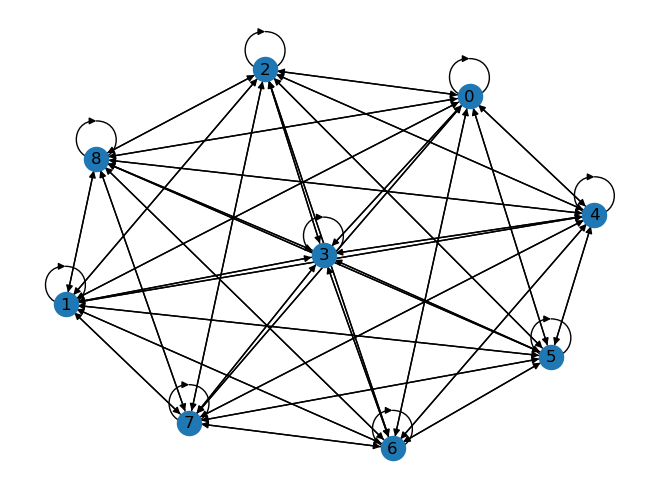

In [11]:
# plot example of one graph/entry in the dataset
nx.draw(to_networkx(ratio_graph_dataset[0]), with_labels=True)

In [16]:
# load the IDs of the train/val/test sets from the ML models
data_split_groups = load_file('data_split_groups.pkl')

## Baseline models

### EC

#### SVM

In [95]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 10, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [96]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


In [97]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
76,sub-88006297,SMC,OCD,ADHD
48,sub-87974709,OCD,OCD,HEALTHY
69,sub-87980913,SMC,HEALTHY,HEALTHY
62,sub-87980197,HEALTHY,HEALTHY,HEALTHY
97,sub-88025597,HEALTHY,HEALTHY,MDD


In [98]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.42      0.38      0.40        45
     HEALTHY       0.43      0.33      0.38        45
         MDD       0.27      0.20      0.23        45
         OCD       0.12      0.07      0.08        45
         SMC       0.31      0.62      0.41        45

    accuracy                           0.32       225
   macro avg       0.31      0.32      0.30       225
weighted avg       0.31      0.32      0.30       225

f1_score: 0.30040819578102096

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.38      0.38      0.38        45
     HEALTHY       0.44      0.42      0.43        45
         MDD       0.24      0.18      0.21        45
         OCD       0.19      0.16      0.17        45
         SMC       0.34      0.51      0.41        45

    accuracy                           0.33       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

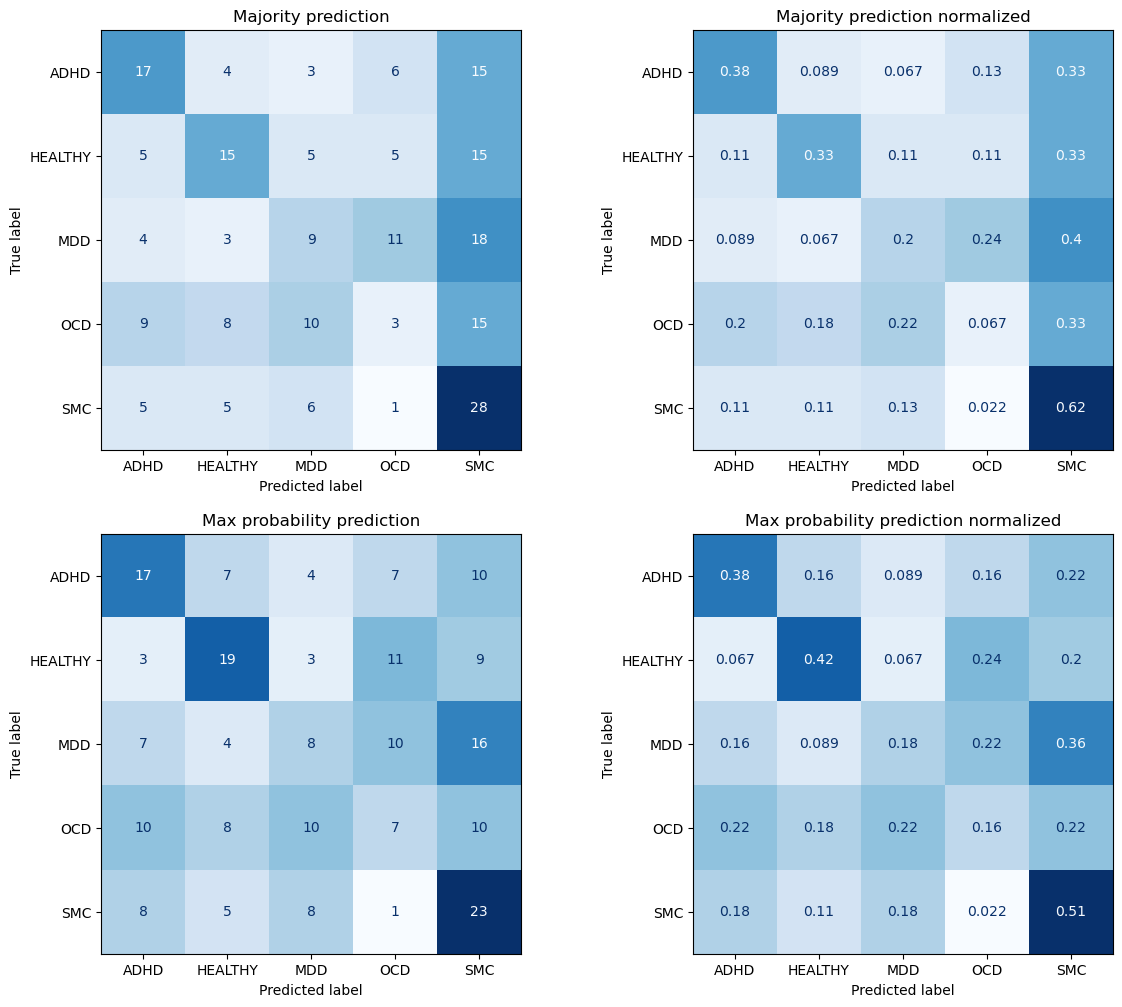

In [99]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [10]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

Parameters of the best model: {'RF__n_estimators': 600, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 100, 'RF__bootstrap': False}


In [11]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 100, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


In [12]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
208,sub-88069793,MDD,MDD,MDD
202,sub-88068797,ADHD,ADHD,ADHD
42,sub-87971197,SMC,SMC,SMC
207,sub-88069649,MDD,MDD,MDD
205,sub-88069113,SMC,SMC,ADHD


In [13]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.44      0.40      0.42        45
     HEALTHY       0.49      0.58      0.53        45
         MDD       0.33      0.24      0.28        45
         OCD       0.28      0.29      0.29        45
         SMC       0.40      0.47      0.43        45

    accuracy                           0.40       225
   macro avg       0.39      0.40      0.39       225
weighted avg       0.39      0.40      0.39       225

f1_score: 0.3899944309095935

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.51      0.40      0.45        45
     HEALTHY       0.45      0.53      0.49        45
         MDD       0.34      0.27      0.30        45
         OCD       0.28      0.29      0.28        45
         SMC       0.40      0.49      0.44        45

    accuracy                           0.40       225
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

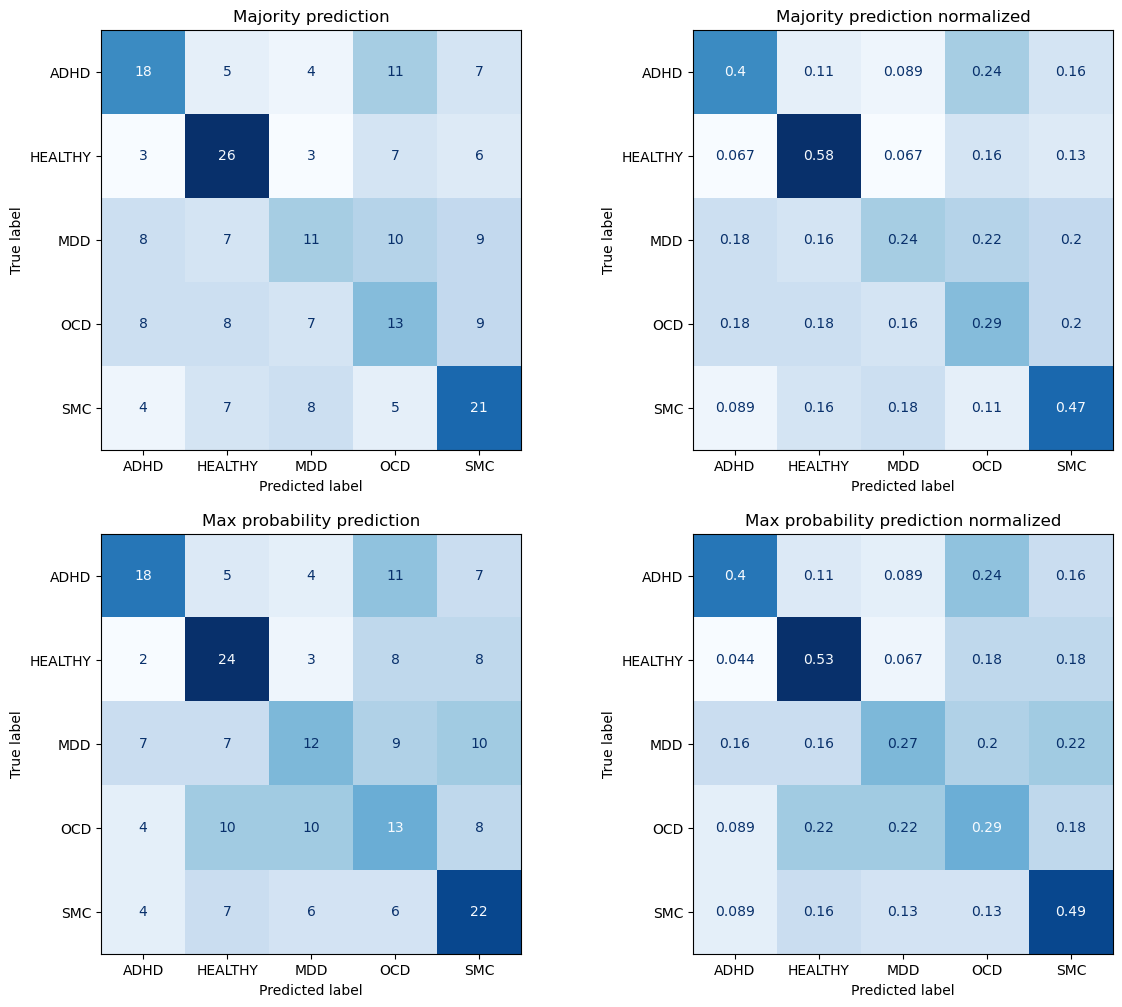

In [14]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [15]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 500, 'gbc__min_samples_split': 5, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.008380358985673617, 'gbc__criterion': 'friedman_mse'}


In [16]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.5, 'n_estimators': 500, 'min_samples_split': 5, 'loss': 'log_loss', 'learning_rate': 0.008380358985673617, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


In [17]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
40,sub-87971021,HEALTHY,HEALTHY,SMC
13,sub-87967781,ADHD,HEALTHY,SMC
108,sub-88036037,OCD,OCD,MDD
138,sub-88049585,SMC,SMC,HEALTHY
142,sub-88052057,OCD,OCD,ADHD


In [18]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.48      0.44      0.46        45
     HEALTHY       0.41      0.44      0.43        45
         MDD       0.40      0.31      0.35        45
         OCD       0.34      0.36      0.35        45
         SMC       0.44      0.51      0.47        45

    accuracy                           0.41       225
   macro avg       0.41      0.41      0.41       225
weighted avg       0.41      0.41      0.41       225

f1_score: 0.41147098418327577

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.51      0.47      0.49        45
     HEALTHY       0.49      0.51      0.50        45
         MDD       0.36      0.27      0.31        45
         OCD       0.33      0.33      0.33        45
         SMC       0.47      0.60      0.52        45

    accuracy                           0.44       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

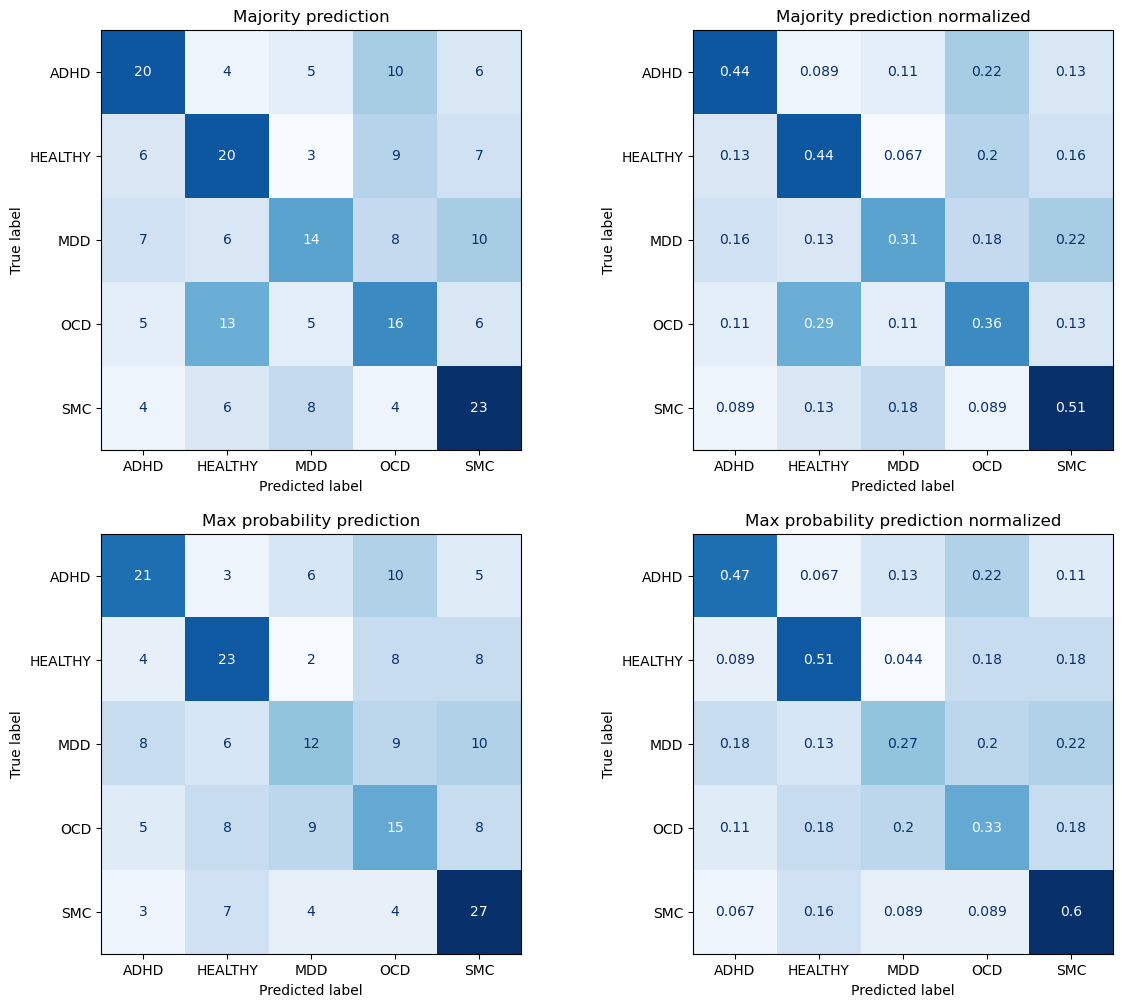

In [19]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

#### SVM

In [20]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [21]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


In [22]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
205,sub-88069113,OCD,OCD,ADHD
108,sub-88036037,SMC,SMC,MDD
110,sub-88037801,SMC,SMC,ADHD
86,sub-88020017,ADHD,ADHD,MDD
119,sub-88042661,ADHD,ADHD,ADHD


In [23]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.57      0.47      0.51        45
     HEALTHY       0.44      0.40      0.42        45
         MDD       0.28      0.22      0.25        45
         OCD       0.39      0.27      0.32        45
         SMC       0.42      0.76      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

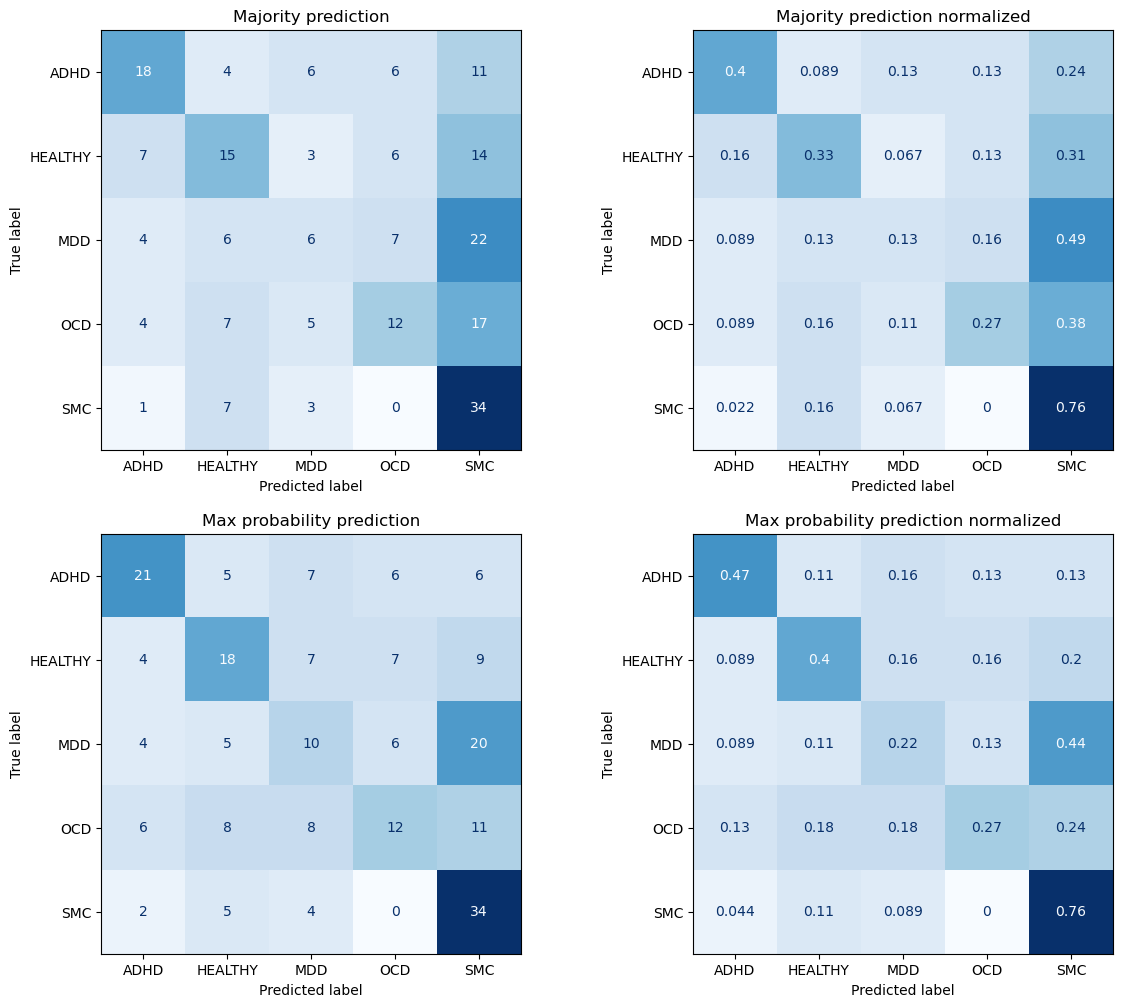

In [24]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [25]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 400, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 1, 'RF__max_features': 'log2', 'RF__max_depth': 80, 'RF__bootstrap': True}


In [26]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


In [27]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
86,sub-88020017,ADHD,ADHD,MDD
150,sub-88053497,OCD,OCD,OCD
112,sub-88039057,SMC,SMC,MDD
31,sub-87969849,SMC,SMC,SMC
95,sub-88024833,HEALTHY,HEALTHY,MDD


In [28]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.51      0.51        45
     HEALTHY       0.39      0.49      0.44        45
         MDD       0.26      0.18      0.21        45
         OCD       0.41      0.36      0.38        45
         SMC       0.40      0.47      0.43        45

    accuracy                           0.40       225
   macro avg       0.39      0.40      0.39       225
weighted avg       0.39      0.40      0.39       225

f1_score: 0.3922376390328448

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.51      0.51        45
     HEALTHY       0.44      0.51      0.47        45
         MDD       0.29      0.20      0.24        45
         OCD       0.41      0.38      0.40        45
         SMC       0.47      0.58      0.52        45

    accuracy                           0.44       225
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

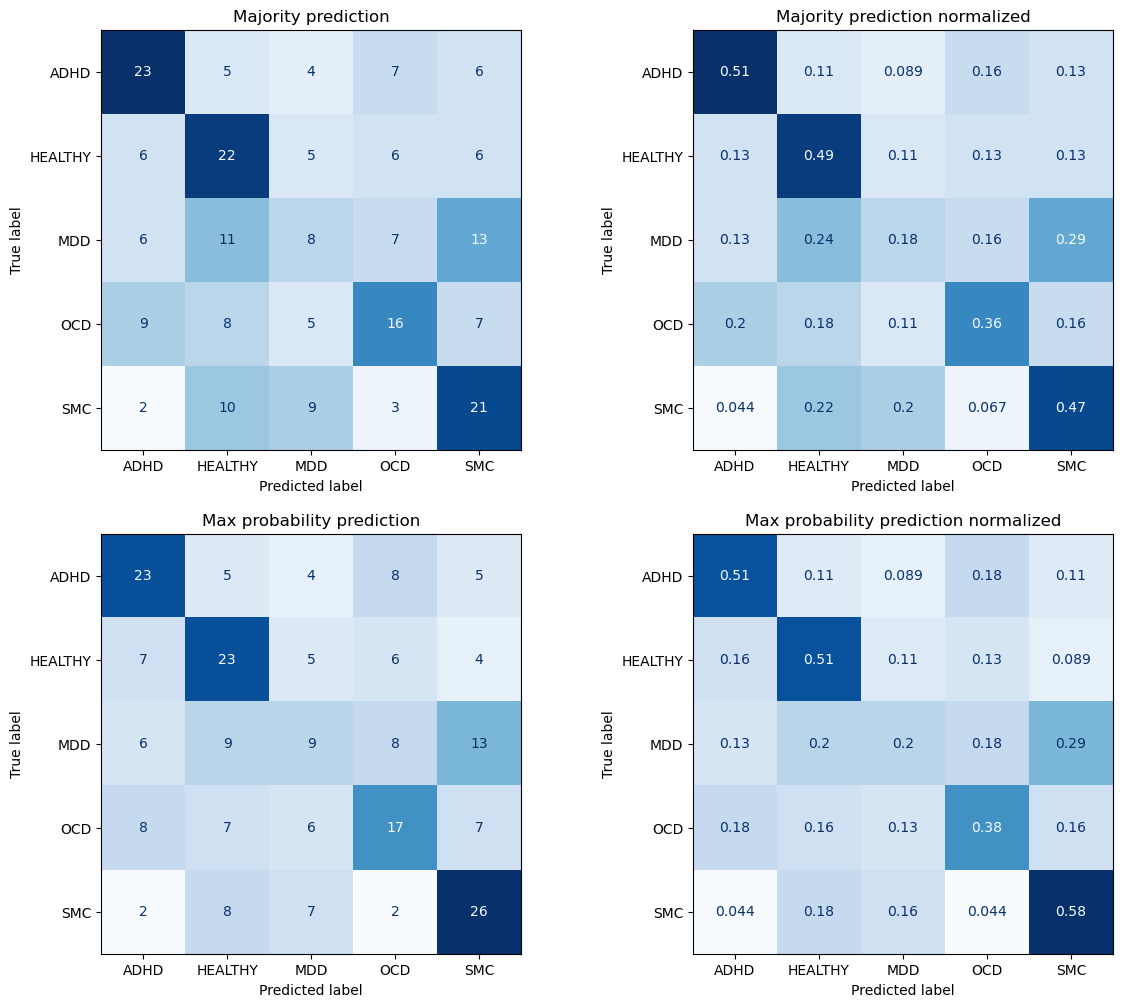

In [29]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [30]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.625, 'gbc__n_estimators': 1000, 'gbc__min_samples_split': 5, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.06052833507809957, 'gbc__criterion': 'friedman_mse'}


In [31]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.625, 'n_estimators': 1000, 'min_samples_split': 5, 'loss': 'log_loss', 'learning_rate': 0.06052833507809957, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished


In [32]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
142,sub-88052057,OCD,OCD,ADHD
123,sub-88044141,ADHD,ADHD,ADHD
183,sub-88063713,OCD,ADHD,OCD
25,sub-87969125,MDD,MDD,SMC
75,sub-88005941,MDD,MDD,MDD


In [33]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.49      0.51      0.50        45
     HEALTHY       0.50      0.56      0.53        45
         MDD       0.34      0.29      0.31        45
         OCD       0.44      0.47      0.45        45
         SMC       0.40      0.38      0.39        45

    accuracy                           0.44       225
   macro avg       0.43      0.44      0.44       225
weighted avg       0.43      0.44      0.44       225

f1_score: 0.43639726048976657

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.51      0.47      0.49        45
     HEALTHY       0.49      0.51      0.50        45
         MDD       0.29      0.27      0.28        45
         OCD       0.42      0.47      0.44        45
         SMC       0.43      0.44      0.44        45

    accuracy                           0.43       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

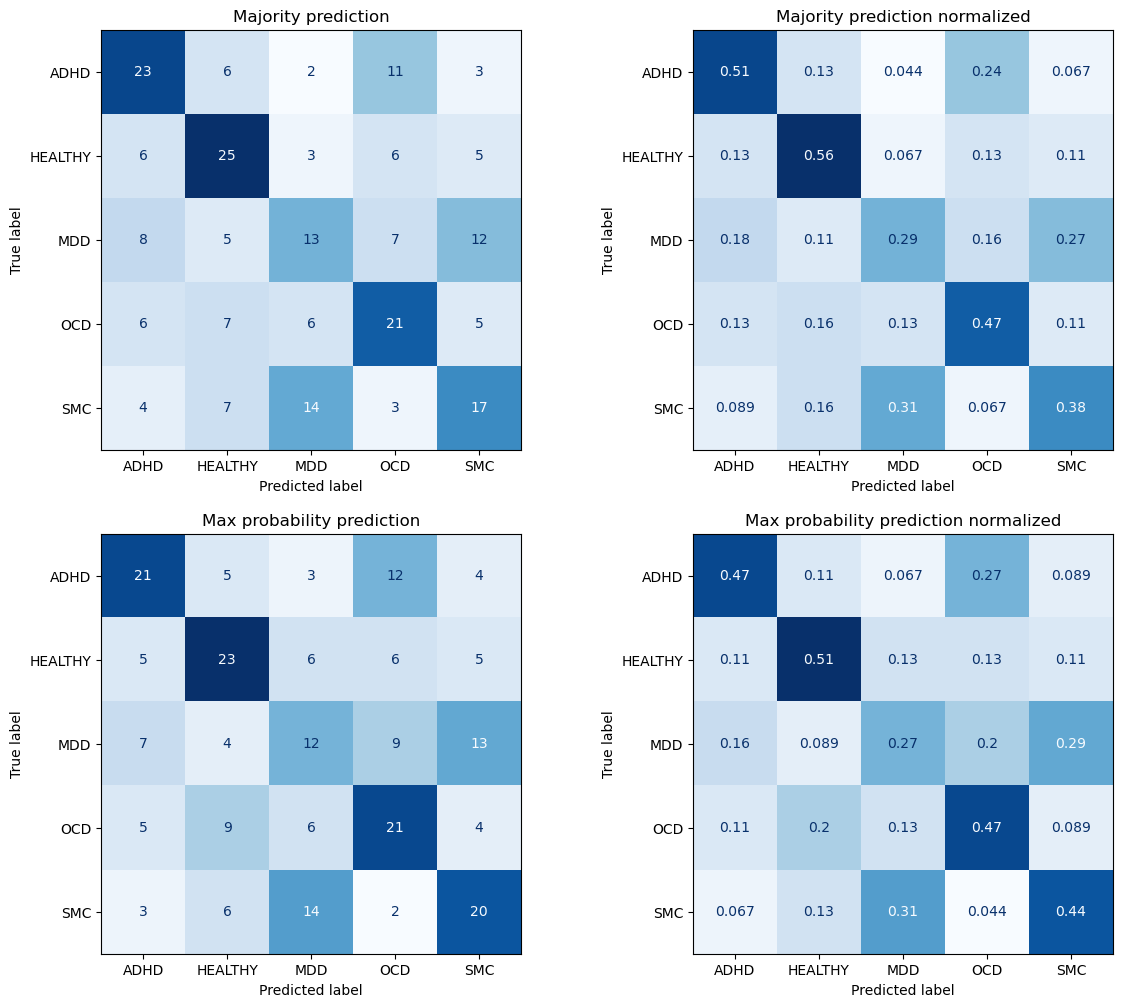

In [34]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

#### SVM

In [35]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 10, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [36]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


In [37]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
132,sub-88047789,SMC,SMC,MDD
188,sub-88064837,OCD,OCD,MDD
192,sub-88065921,ADHD,ADHD,ADHD
143,sub-88052241,SMC,ADHD,ADHD
80,sub-88016105,HEALTHY,HEALTHY,MDD


In [38]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.34      0.42      0.38        45
     HEALTHY       0.30      0.29      0.30        45
         MDD       0.14      0.11      0.12        45
         OCD       0.28      0.22      0.25        45
         SMC       0.16      0.20      0.18        45

    accuracy                           0.25       225
   macro avg       0.25      0.25      0.24       225
weighted avg       0.25      0.25      0.24       225

f1_score: 0.24472114989276705

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.39      0.53      0.45        45
     HEALTHY       0.25      0.29      0.27        45
         MDD       0.16      0.11      0.13        45
         OCD       0.28      0.20      0.23        45
         SMC       0.18      0.20      0.19        45

    accuracy                           0.27       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

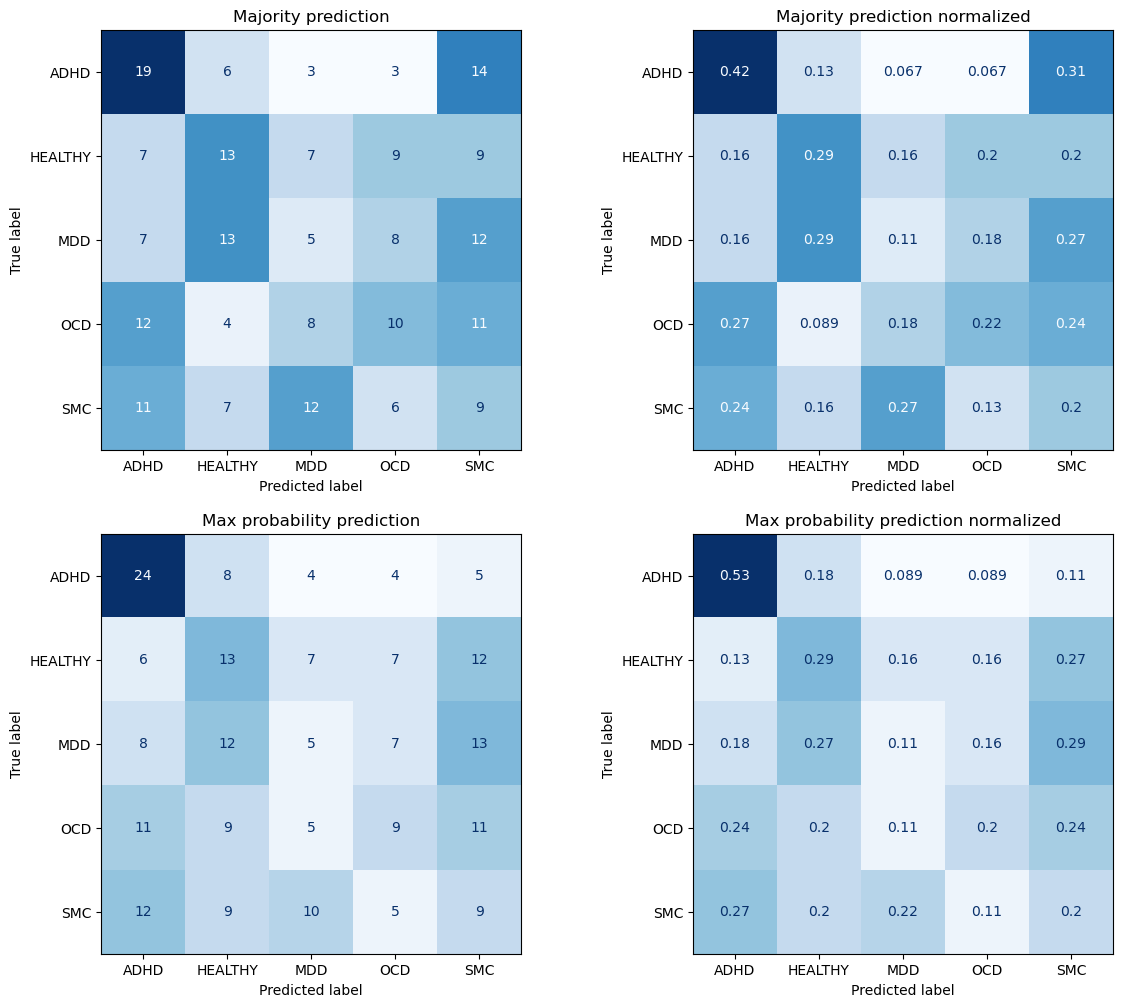

In [39]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [40]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 400, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 4, 'RF__max_features': 'sqrt', 'RF__max_depth': 60, 'RF__bootstrap': True}


In [41]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


In [42]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
220,sub-88075593,SMC,SMC,ADHD
52,sub-87976369,OCD,OCD,HEALTHY
91,sub-88023213,SMC,SMC,ADHD
62,sub-87980197,HEALTHY,HEALTHY,HEALTHY
162,sub-88056557,SMC,SMC,OCD


In [43]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.45      0.56      0.50        45
     HEALTHY       0.28      0.40      0.33        45
         MDD       0.21      0.13      0.16        45
         OCD       0.24      0.22      0.23        45
         SMC       0.29      0.22      0.25        45

    accuracy                           0.31       225
   macro avg       0.29      0.31      0.29       225
weighted avg       0.29      0.31      0.29       225

f1_score: 0.29395108166006956

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.48      0.56      0.52        45
     HEALTHY       0.37      0.51      0.43        45
         MDD       0.21      0.13      0.16        45
         OCD       0.40      0.36      0.38        45
         SMC       0.29      0.27      0.28        45

    accuracy                           0.36       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

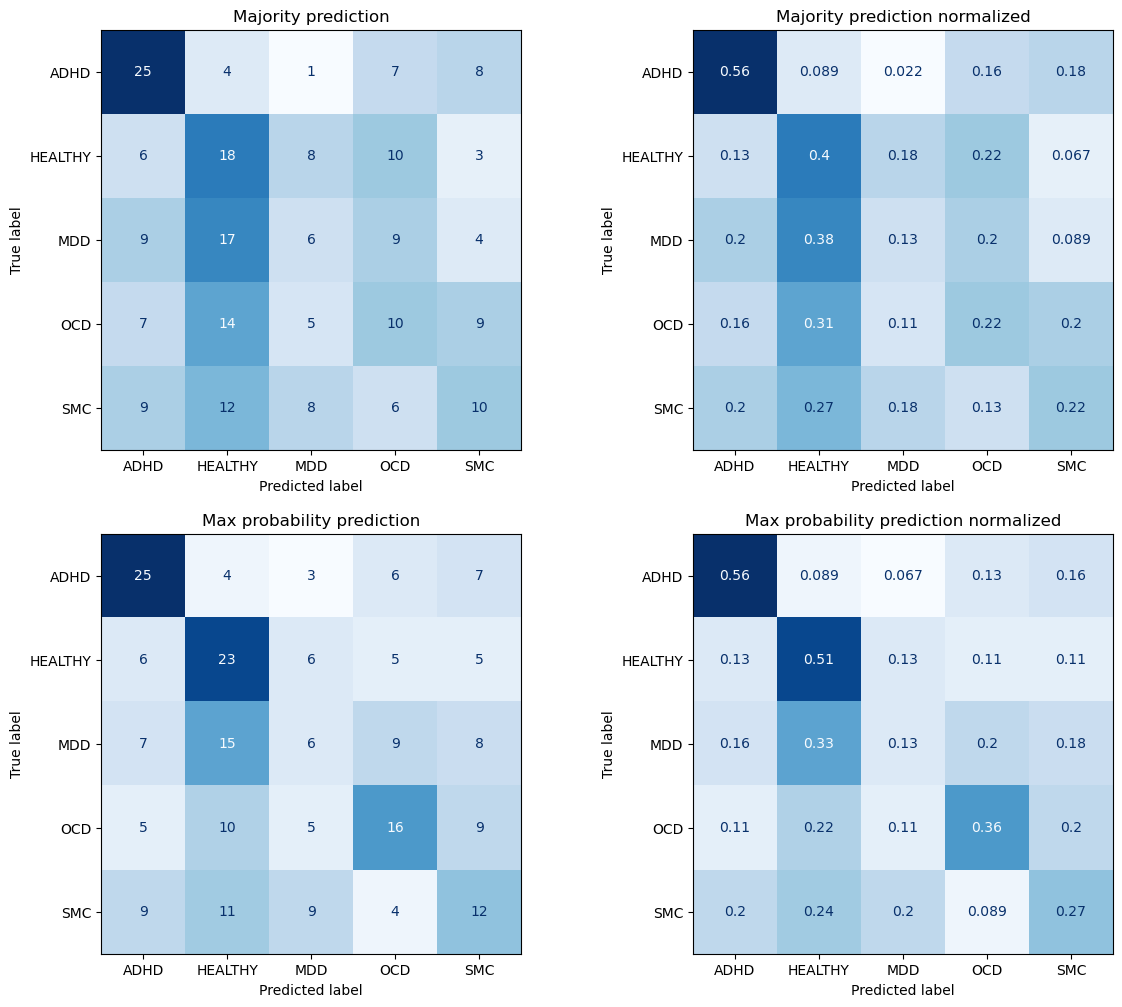

In [44]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [45]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 1.0, 'gbc__n_estimators': 300, 'gbc__min_samples_split': 2, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.0031815429912507897, 'gbc__criterion': 'friedman_mse'}


In [46]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'loss': 'log_loss', 'learning_rate': 0.0031815429912507897, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [47]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
83,sub-88017765,HEALTHY,HEALTHY,MDD
8,sub-87967325,OCD,OCD,SMC
101,sub-88028433,OCD,OCD,ADHD
97,sub-88025597,HEALTHY,HEALTHY,MDD
166,sub-88057681,HEALTHY,HEALTHY,OCD


In [48]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.48      0.58      0.53        45
     HEALTHY       0.39      0.33      0.36        45
         MDD       0.38      0.13      0.20        45
         OCD       0.28      0.51      0.36        45
         SMC       0.31      0.24      0.28        45

    accuracy                           0.36       225
   macro avg       0.37      0.36      0.34       225
weighted avg       0.37      0.36      0.34       225

f1_score: 0.34412486885398286

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.47      0.56      0.51        45
     HEALTHY       0.38      0.44      0.41        45
         MDD       0.21      0.07      0.10        45
         OCD       0.29      0.36      0.32        45
         SMC       0.29      0.31      0.30        45

    accuracy                           0.35       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

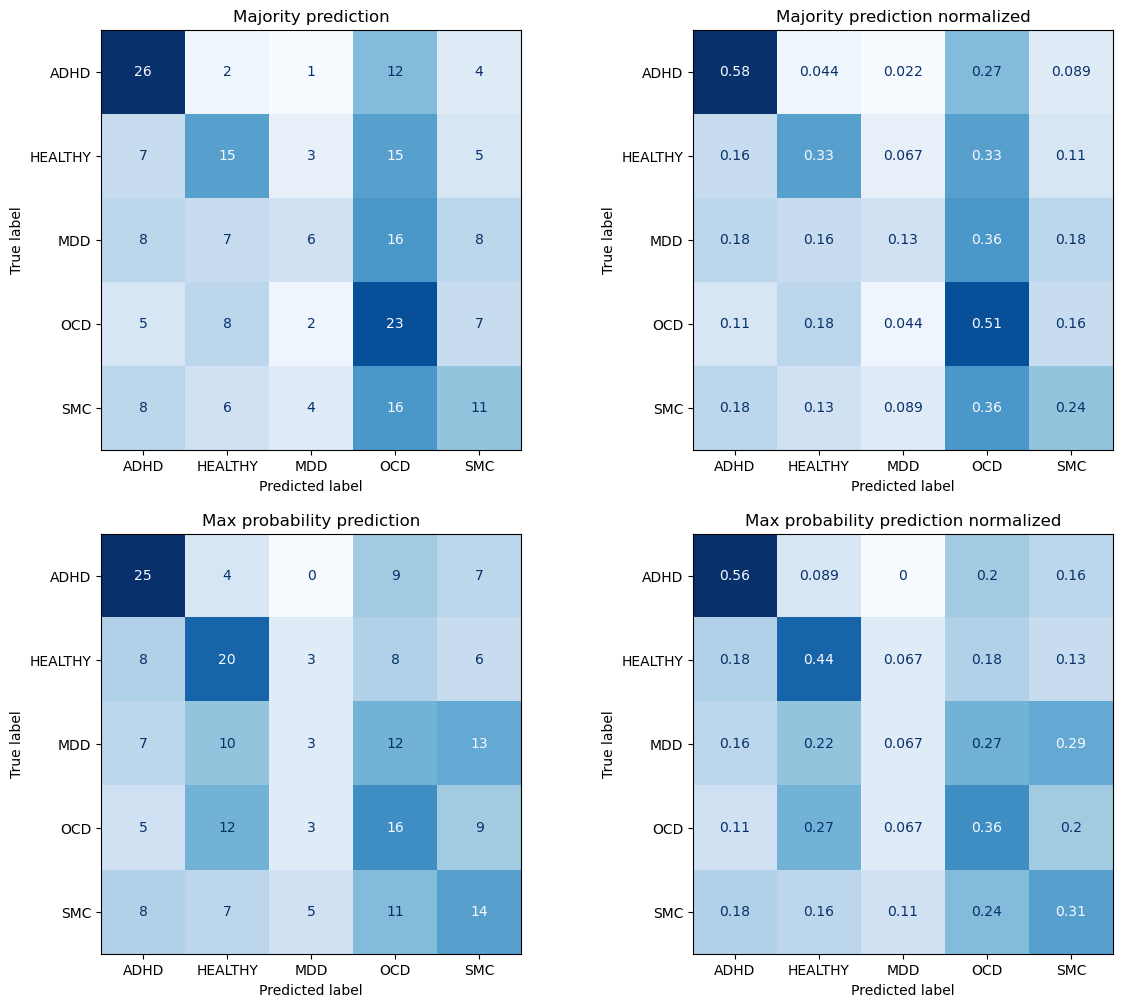

In [49]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

## Extended models

### EC

#### SVM

In [50]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 0.01, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [51]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 0.01, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [52]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
18,sub-87968405,SMC,MDD,SMC
129,sub-88046393,HEALTHY,HEALTHY,ADHD
100,sub-88027577,SMC,HEALTHY,ADHD
135,sub-88048549,SMC,MDD,OCD
36,sub-87970389,HEALTHY,HEALTHY,SMC


In [53]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       1.00      0.02      0.04        45
     HEALTHY       0.20      0.20      0.20        45
         MDD       0.00      0.00      0.00        45
         OCD       0.00      0.00      0.00        45
         SMC       0.20      0.80      0.32        45

    accuracy                           0.20       225
   macro avg       0.28      0.20      0.11       225
weighted avg       0.28      0.20      0.11       225

f1_score: 0.11298136645962735

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        45
     HEALTHY       0.20      0.60      0.30        45
         MDD       0.20      0.20      0.20        45
         OCD       0.20      0.20      0.20        45
         SMC       0.00      0.00      0.00        45

    accuracy                           0.20       225
   macro avg     

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\an

Text(0.5, 1.0, 'Max probability prediction normalized')

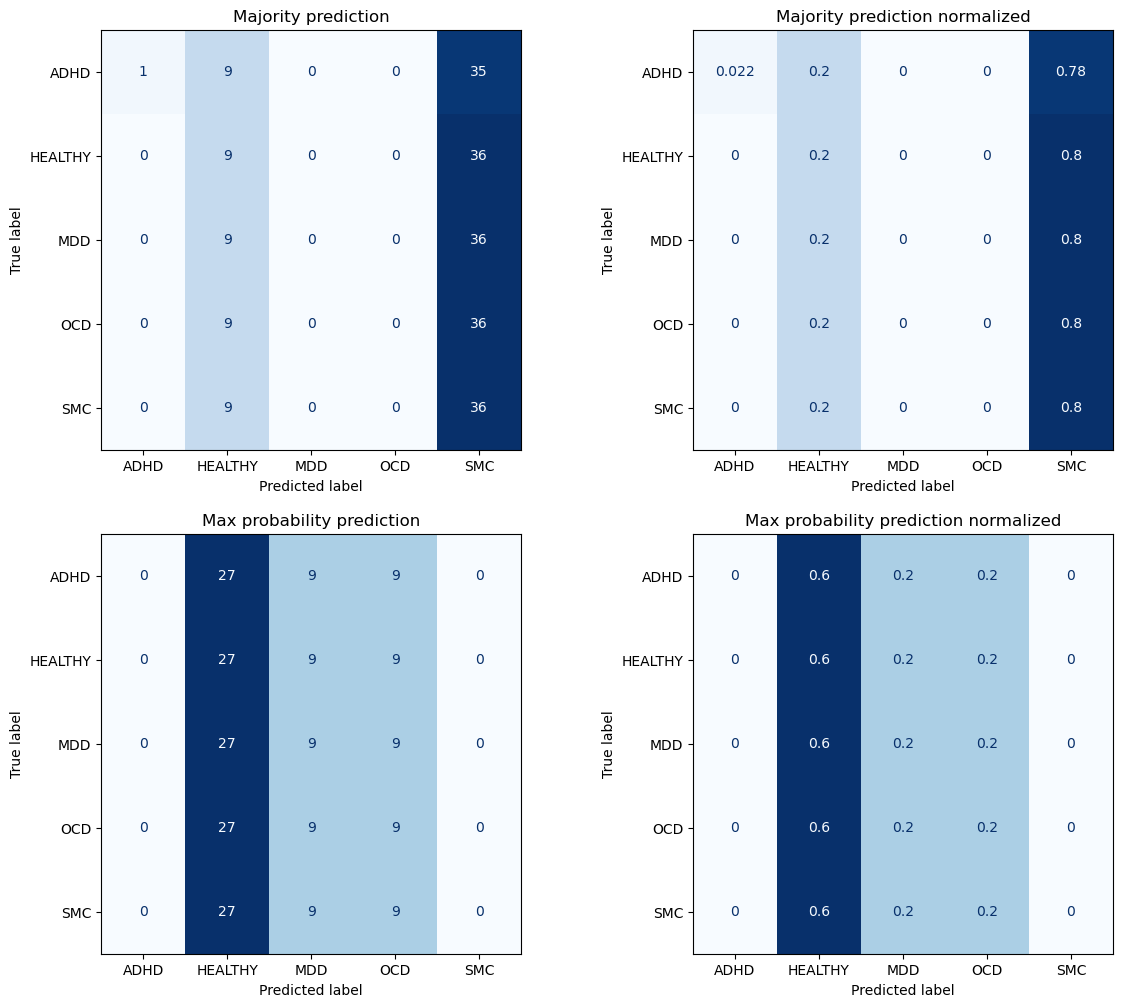

In [54]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [55]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 1200, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 70, 'RF__bootstrap': True}


In [56]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


In [57]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
17,sub-87968229,SMC,SMC,SMC
157,sub-88054533,SMC,SMC,ADHD
166,sub-88057681,HEALTHY,HEALTHY,OCD
9,sub-87967417,ADHD,OCD,SMC
193,sub-88066413,HEALTHY,HEALTHY,OCD


In [58]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.43      0.49      0.46        45
     HEALTHY       0.45      0.53      0.49        45
         MDD       0.42      0.38      0.40        45
         OCD       0.33      0.27      0.30        45
         SMC       0.42      0.42      0.42        45

    accuracy                           0.42       225
   macro avg       0.41      0.42      0.41       225
weighted avg       0.41      0.42      0.41       225

f1_score: 0.41332955404383975

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.52      0.51      0.52        45
     HEALTHY       0.52      0.58      0.55        45
         MDD       0.40      0.36      0.38        45
         OCD       0.38      0.33      0.35        45
         SMC       0.45      0.51      0.48        45

    accuracy                           0.46       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

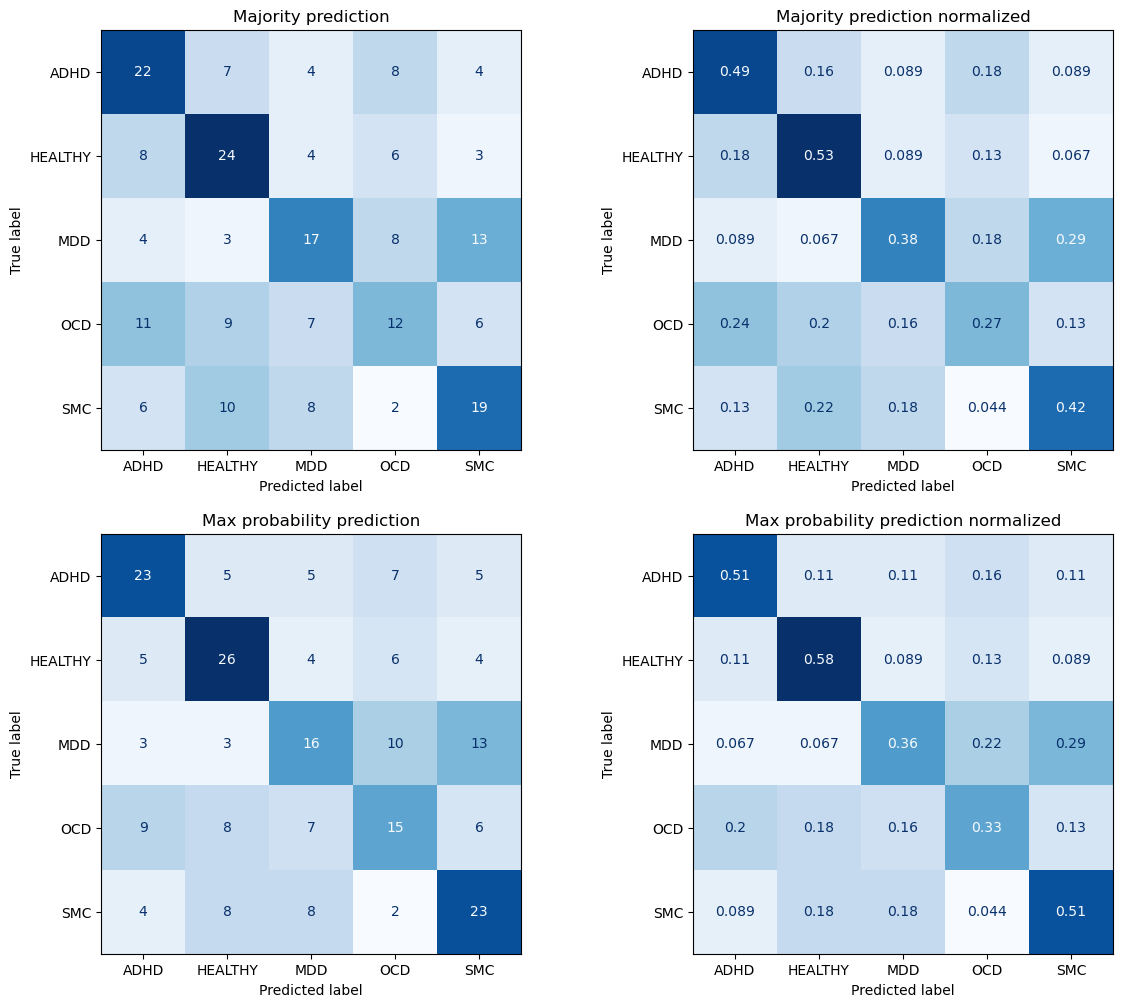

In [59]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [60]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 700, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.022013224311665046, 'gbc__criterion': 'friedman_mse'}


In [61]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.5, 'n_estimators': 700, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.022013224311665046, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


In [62]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
57,sub-87976641,HEALTHY,HEALTHY,HEALTHY
65,sub-87980373,OCD,OCD,HEALTHY
212,sub-88073249,SMC,OCD,OCD
24,sub-87968945,SMC,SMC,SMC
125,sub-88044545,MDD,MDD,MDD


In [63]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.56      0.60      0.58        45
     HEALTHY       0.50      0.51      0.51        45
         MDD       0.41      0.38      0.40        45
         OCD       0.47      0.44      0.45        45
         SMC       0.62      0.64      0.63        45

    accuracy                           0.52       225
   macro avg       0.51      0.52      0.51       225
weighted avg       0.51      0.52      0.51       225

f1_score: 0.5132937482296561

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.59      0.53      0.56        45
     HEALTHY       0.50      0.53      0.52        45
         MDD       0.40      0.38      0.39        45
         OCD       0.44      0.44      0.44        45
         SMC       0.61      0.67      0.64        45

    accuracy                           0.51       225
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

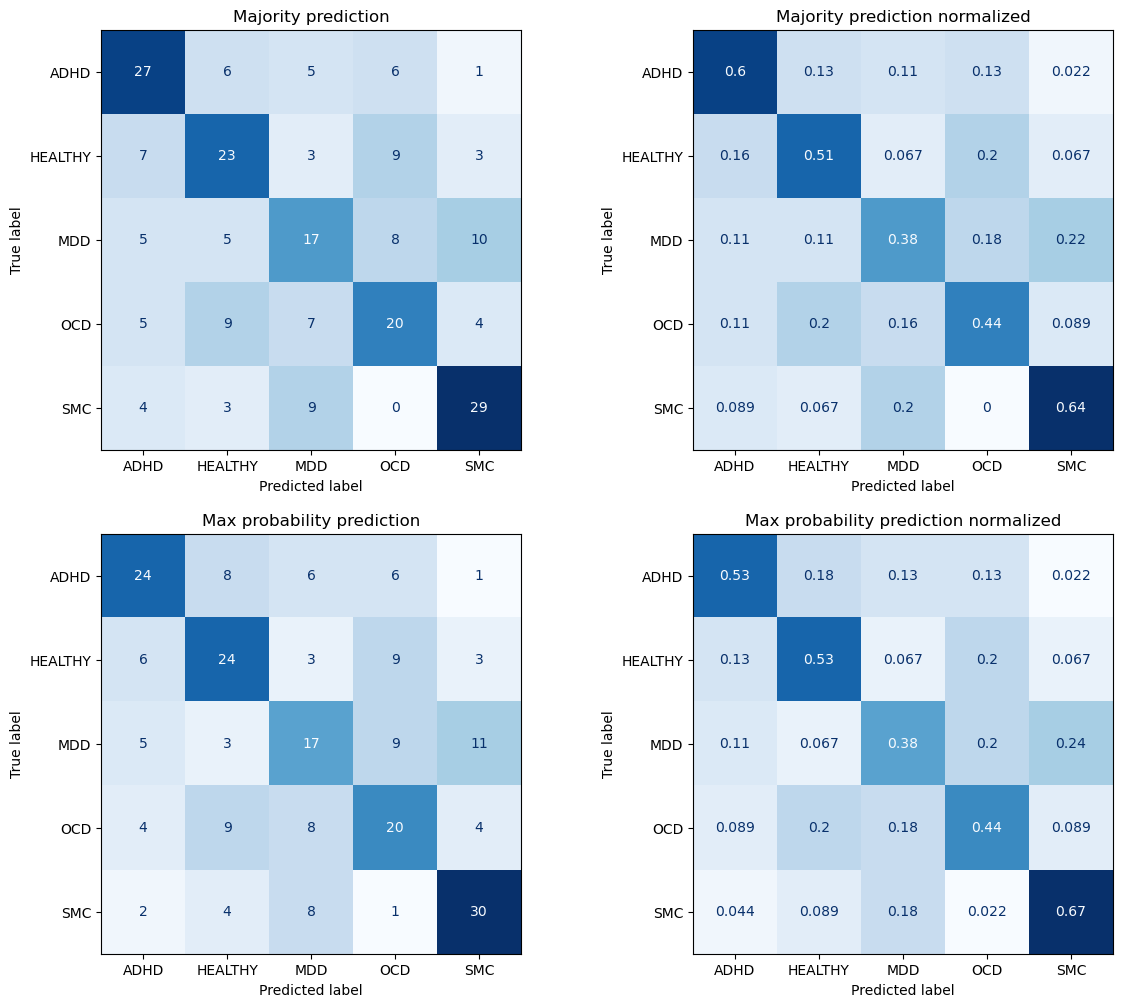

In [64]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

#### SVM

In [65]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 0.01, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [66]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 0.01, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [67]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
38,sub-87970881,SMC,SMC,SMC
205,sub-88069113,SMC,SMC,ADHD
178,sub-88061325,SMC,HEALTHY,ADHD
111,sub-88038789,SMC,SMC,ADHD
213,sub-88073521,SMC,SMC,ADHD


In [68]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.24      0.11      0.15        45
     HEALTHY       0.00      0.00      0.00        45
         MDD       0.00      0.00      0.00        45
         OCD       0.50      0.07      0.12        45
         SMC       0.23      0.96      0.37        45

    accuracy                           0.23       225
   macro avg       0.19      0.23      0.13       225
weighted avg       0.19      0.23      0.13       225

f1_score: 0.12702393142943832

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        45
     HEALTHY       0.20      0.20      0.20        45
         MDD       0.00      0.00      0.00        45
         OCD       0.20      0.20      0.20        45
         SMC       0.20      0.60      0.30        45

    accuracy                           0.20       225
   macro avg     

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Max probability prediction normalized')

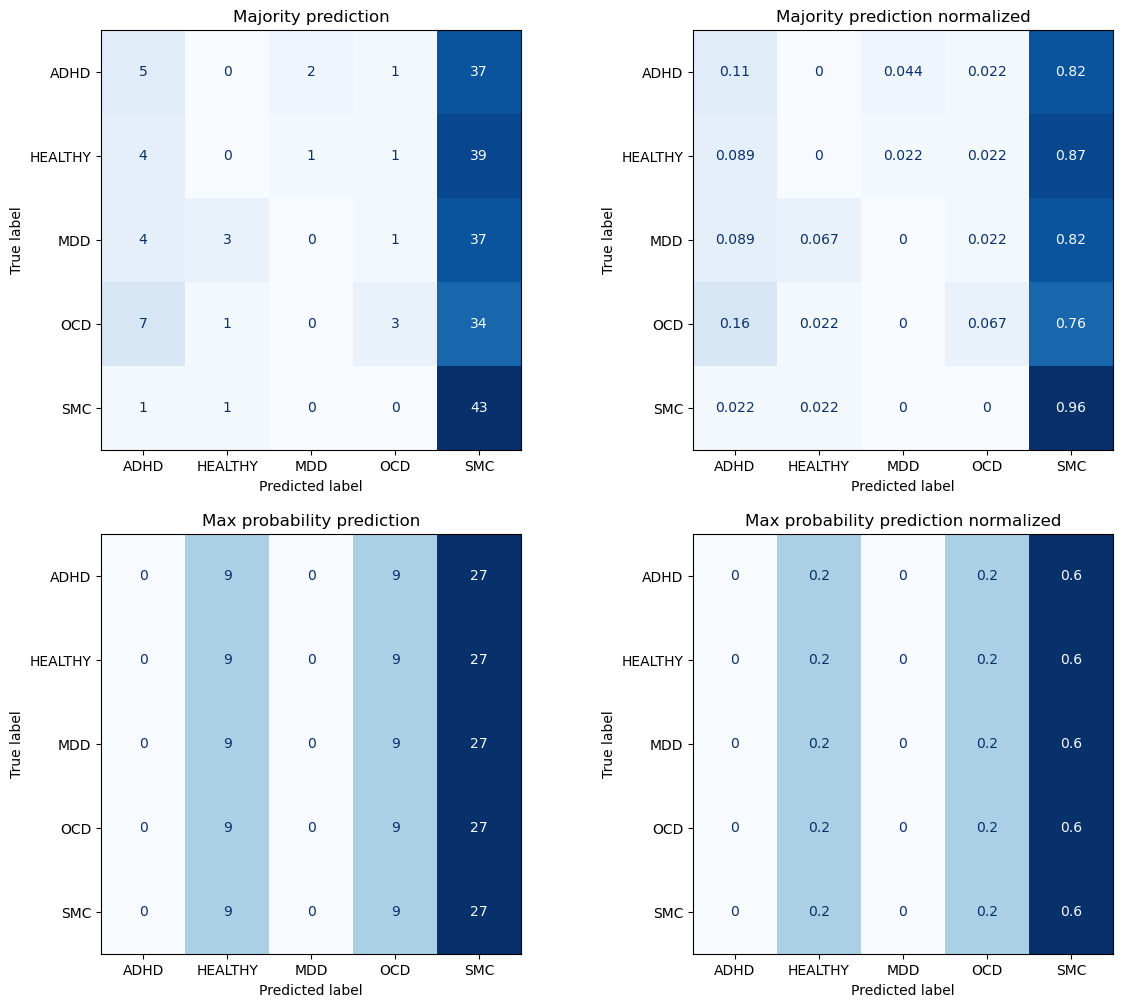

In [69]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [70]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 2000, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 30, 'RF__bootstrap': True}


In [71]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


In [72]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
174,sub-88059397,HEALTHY,HEALTHY,HEALTHY
207,sub-88069649,SMC,SMC,MDD
89,sub-88022677,OCD,OCD,ADHD
29,sub-87969665,SMC,SMC,SMC
136,sub-88048729,OCD,OCD,HEALTHY


In [73]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.55      0.58      0.57        45
     HEALTHY       0.38      0.51      0.44        45
         MDD       0.35      0.18      0.24        45
         OCD       0.45      0.38      0.41        45
         SMC       0.49      0.62      0.55        45

    accuracy                           0.45       225
   macro avg       0.44      0.45      0.44       225
weighted avg       0.44      0.45      0.44       225

f1_score: 0.4394529818213298

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.51      0.51        45
     HEALTHY       0.39      0.49      0.44        45
         MDD       0.31      0.20      0.24        45
         OCD       0.45      0.38      0.41        45
         SMC       0.52      0.64      0.57        45

    accuracy                           0.44       225
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

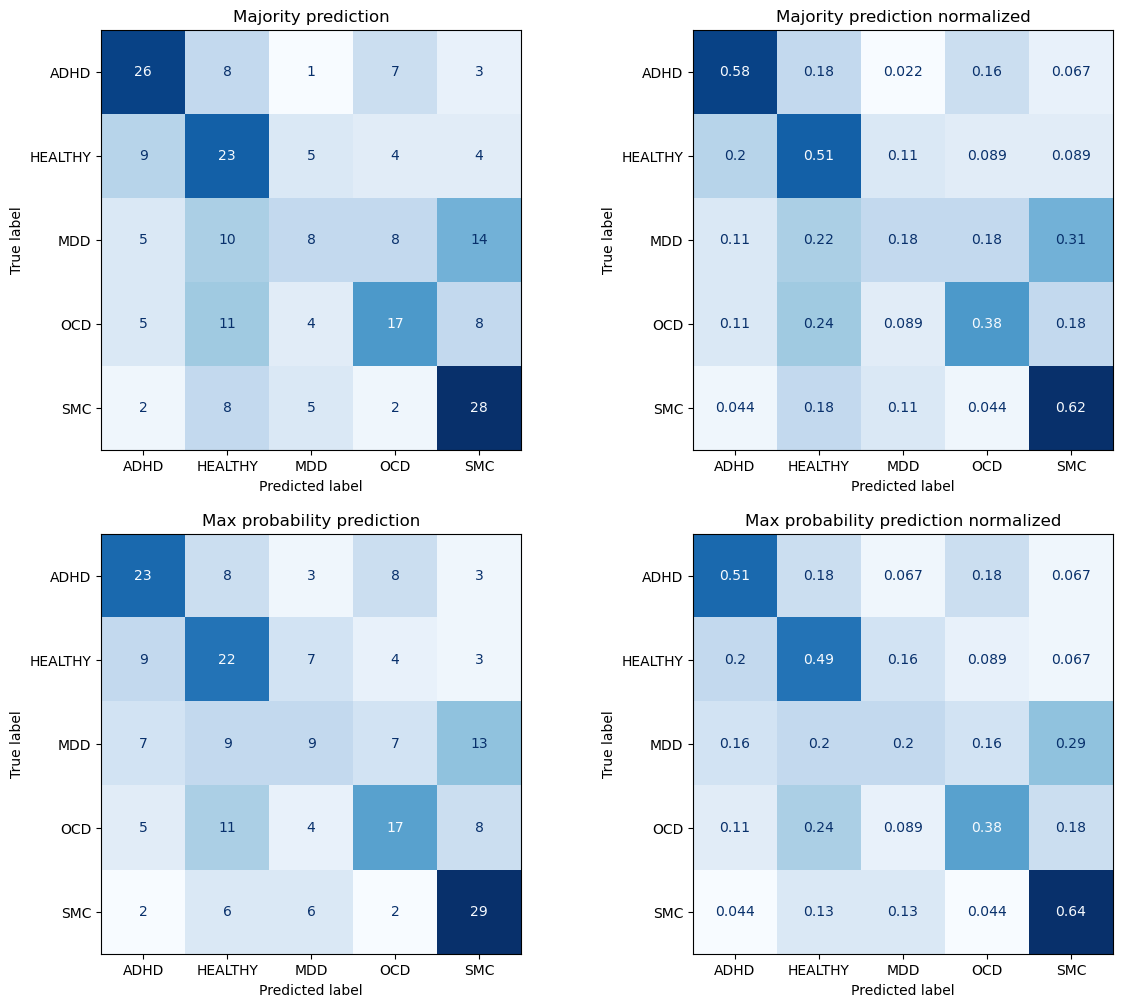

In [74]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [75]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 900, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.0756037588366562, 'gbc__criterion': 'friedman_mse'}


In [76]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.5, 'n_estimators': 900, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.0756037588366562, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.7min finished


In [77]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
128,sub-88046349,OCD,OCD,MDD
40,sub-87971021,SMC,SMC,SMC
122,sub-88044093,ADHD,ADHD,ADHD
59,sub-87976817,SMC,HEALTHY,HEALTHY
219,sub-88075053,OCD,OCD,HEALTHY


In [78]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.49      0.49        45
     HEALTHY       0.41      0.40      0.40        45
         MDD       0.32      0.31      0.31        45
         OCD       0.52      0.56      0.54        45
         SMC       0.58      0.58      0.58        45

    accuracy                           0.47       225
   macro avg       0.47      0.47      0.47       225
weighted avg       0.47      0.47      0.47       225

f1_score: 0.4657790664894688

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.48      0.47      0.47        45
     HEALTHY       0.40      0.36      0.38        45
         MDD       0.30      0.29      0.29        45
         OCD       0.49      0.53      0.51        45
         SMC       0.58      0.62      0.60        45

    accuracy                           0.45       225
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

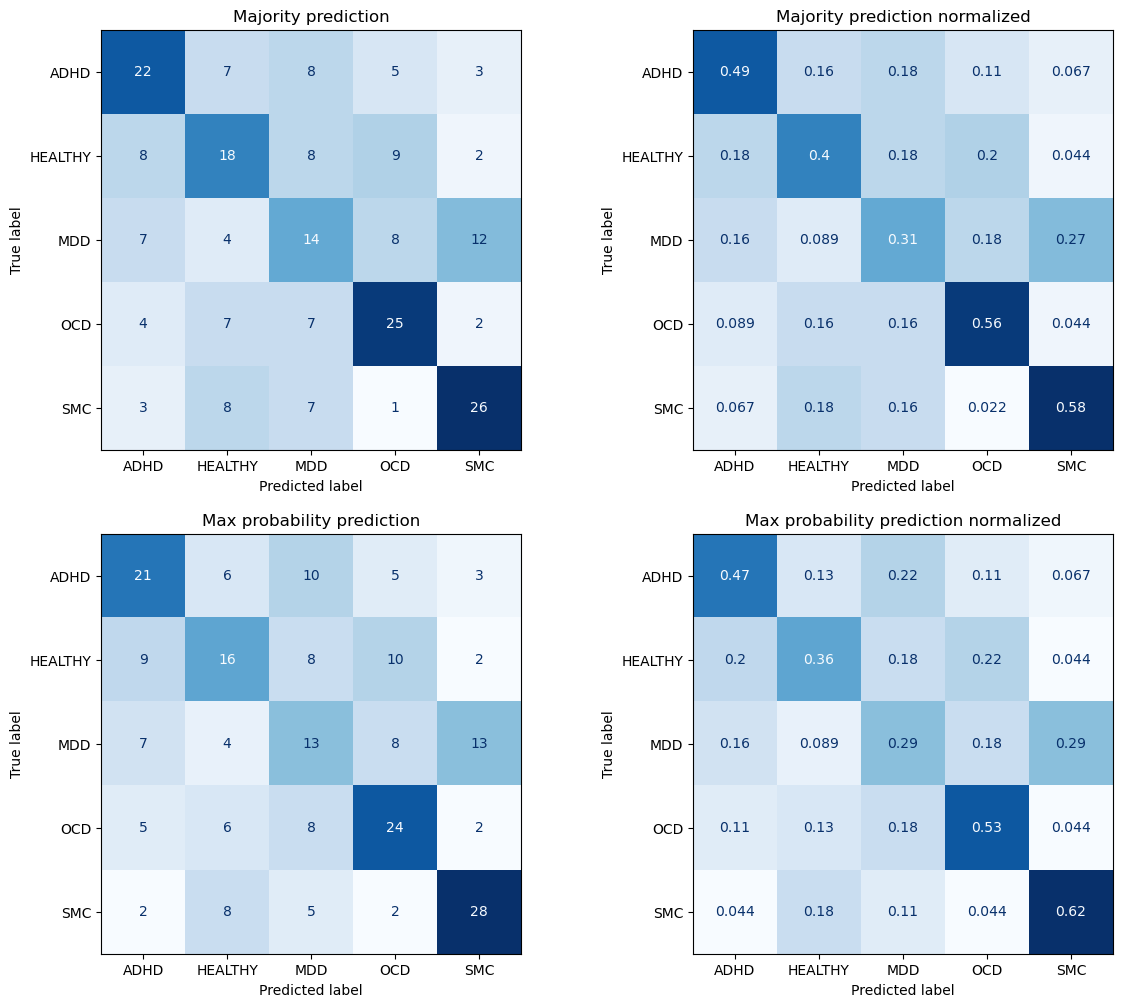

In [79]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

#### SVM

In [80]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [81]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished


In [82]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
44,sub-87971373,HEALTHY,SMC,SMC
209,sub-88071093,HEALTHY,HEALTHY,OCD
151,sub-88053545,HEALTHY,SMC,HEALTHY
204,sub-88068981,OCD,MDD,OCD
181,sub-88062949,OCD,OCD,OCD


In [83]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        45
     HEALTHY       0.19      0.49      0.28        45
         MDD       0.19      0.07      0.10        45
         OCD       0.47      0.16      0.23        45
         SMC       0.23      0.40      0.30        45

    accuracy                           0.22       225
   macro avg       0.22      0.22      0.18       225
weighted avg       0.22      0.22      0.18       225

f1_score: 0.18070110320651614

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.35      0.16      0.22        45
     HEALTHY       0.15      0.13      0.14        45
         MDD       0.22      0.13      0.17        45
         OCD       0.37      0.22      0.28        45
         SMC       0.21      0.53      0.31        45

    accuracy                           0.24       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

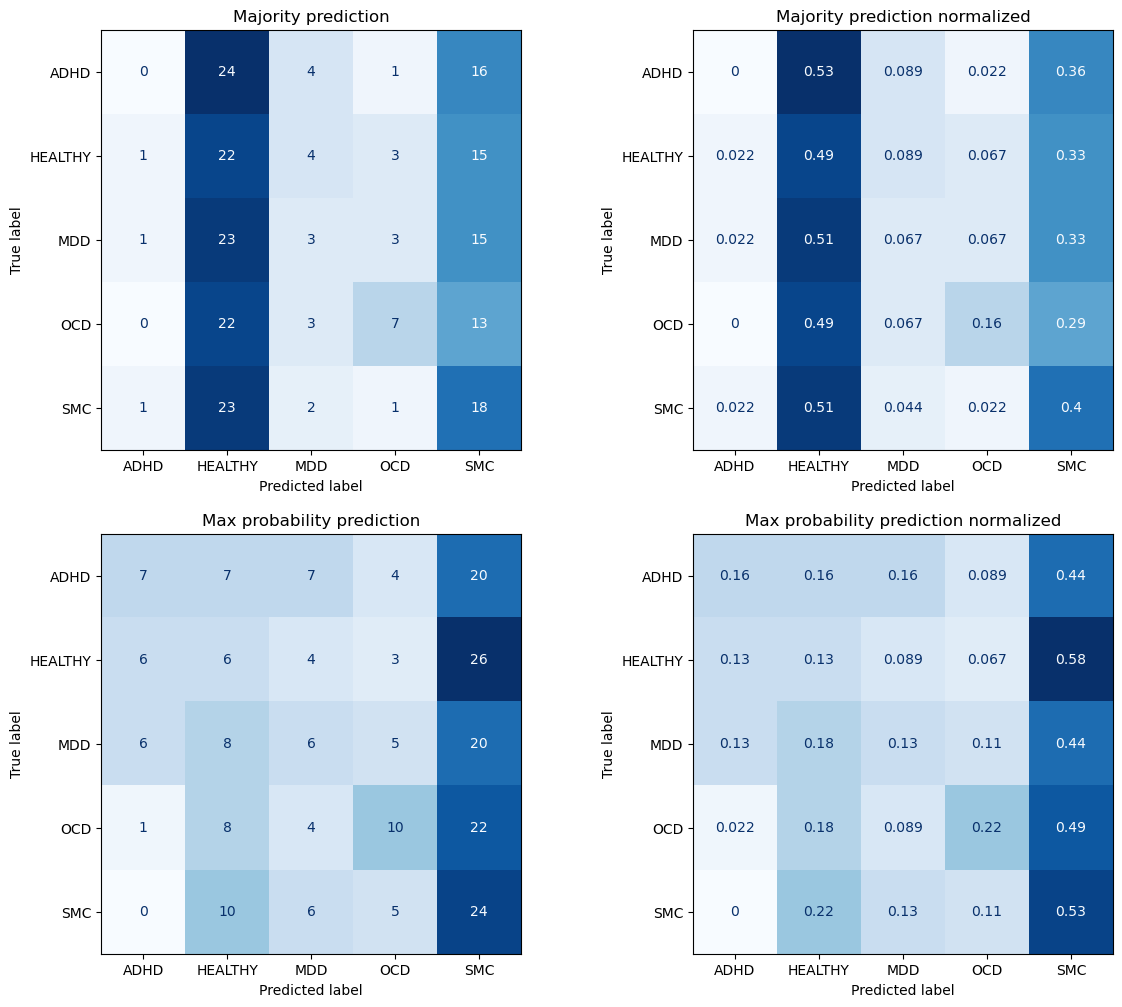

In [84]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [85]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 1200, 'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_features': 'log2', 'RF__max_depth': 80, 'RF__bootstrap': True}


In [86]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


In [87]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
122,sub-88044093,OCD,OCD,ADHD
209,sub-88071093,ADHD,ADHD,OCD
46,sub-87974621,OCD,OCD,HEALTHY
89,sub-88022677,ADHD,ADHD,ADHD
24,sub-87968945,HEALTHY,HEALTHY,SMC


In [88]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.53      0.52        45
     HEALTHY       0.39      0.42      0.40        45
         MDD       0.25      0.24      0.25        45
         OCD       0.30      0.24      0.27        45
         SMC       0.30      0.31      0.30        45

    accuracy                           0.35       225
   macro avg       0.35      0.35      0.35       225
weighted avg       0.35      0.35      0.35       225

f1_score: 0.34804317433134835

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.45      0.51      0.48        45
     HEALTHY       0.40      0.40      0.40        45
         MDD       0.26      0.22      0.24        45
         OCD       0.32      0.29      0.30        45
         SMC       0.30      0.33      0.32        45

    accuracy                           0.35       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

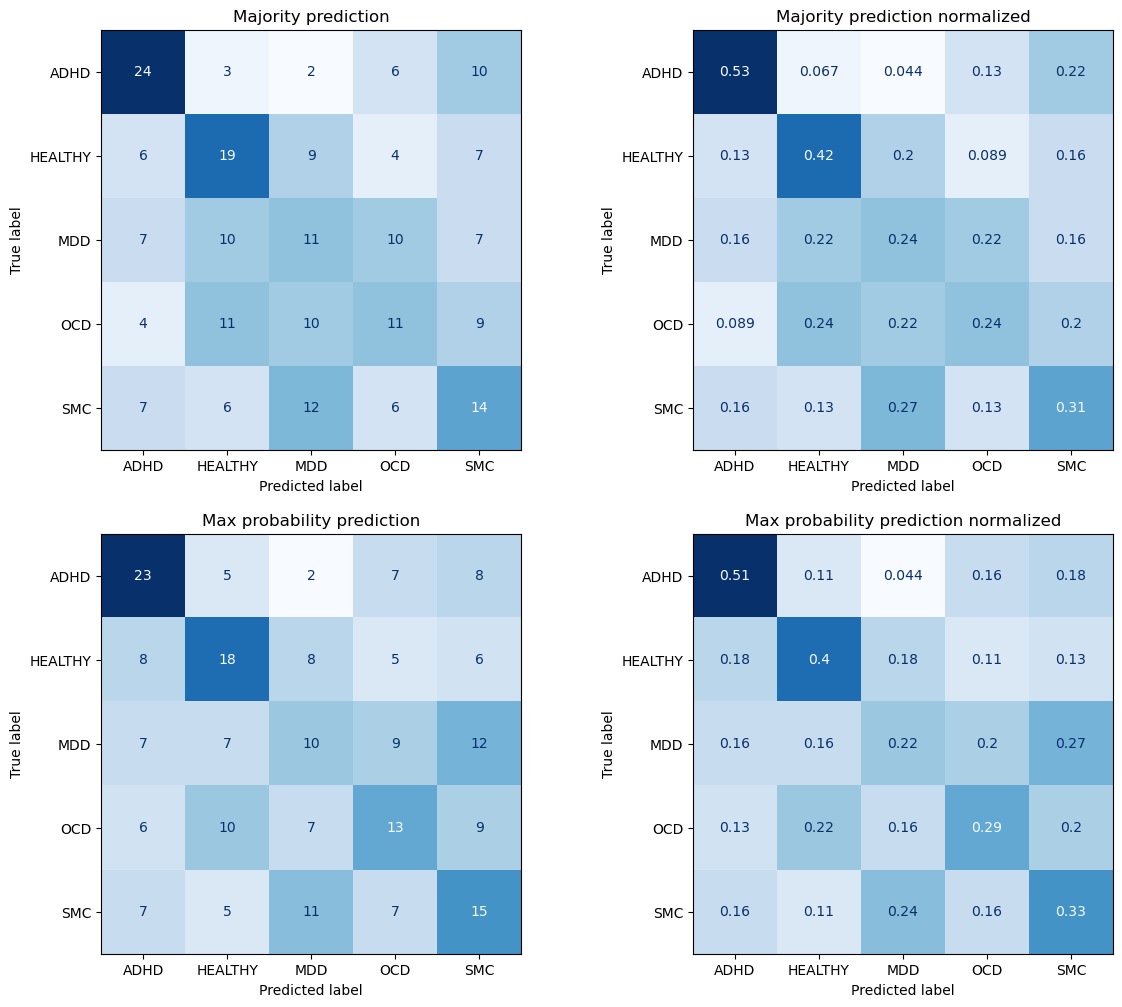

In [89]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [90]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.75, 'gbc__n_estimators': 1000, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.0255077211696248, 'gbc__criterion': 'friedman_mse'}


In [91]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.75, 'n_estimators': 1000, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.0255077211696248, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished


In [92]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
76,sub-88006297,SMC,SMC,ADHD
91,sub-88023213,SMC,SMC,ADHD
34,sub-87970297,SMC,SMC,SMC
121,sub-88043021,ADHD,ADHD,MDD
197,sub-88067449,HEALTHY,HEALTHY,ADHD


In [93]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.56      0.53        45
     HEALTHY       0.38      0.38      0.38        45
         MDD       0.27      0.24      0.26        45
         OCD       0.40      0.38      0.39        45
         SMC       0.39      0.40      0.40        45

    accuracy                           0.39       225
   macro avg       0.39      0.39      0.39       225
weighted avg       0.39      0.39      0.39       225

f1_score: 0.38837511054157325

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.53      0.53        45
     HEALTHY       0.39      0.40      0.40        45
         MDD       0.27      0.27      0.27        45
         OCD       0.36      0.33      0.34        45
         SMC       0.38      0.40      0.39        45

    accuracy                           0.39       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

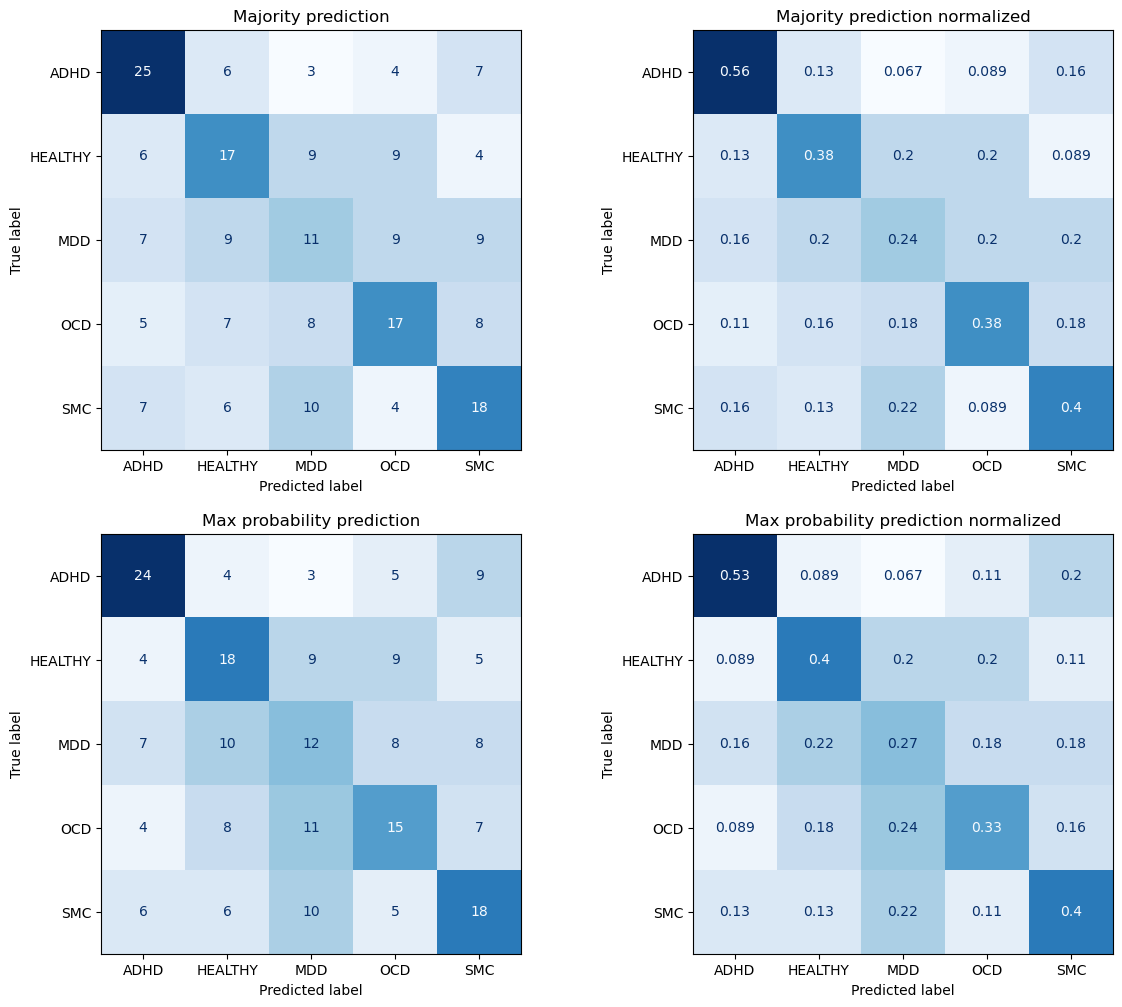

In [94]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

## GNNs

#### GCNConv with log_softmax activation function and NLLLoss

In [12]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from torch.nn import Dropout1d
import seaborn as sns
import matplotlib.pyplot as plt

n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
param = 64
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class GCN(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, dropout):
        super(GCN, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        self.conv1 = GCNConv(n_features, param, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(param)
        self.do1 = Dropout1d(p=dropout)
        self.conv2 = GCNConv(param, param, cached=False)
        self.bn2 = BatchNorm1d(param)
        self.do2 = Dropout1d(p=dropout)
        self.fc1 = Linear(param, param)
        self.bn3 = BatchNorm1d(param)
        self.do3 = Dropout1d(p=dropout)
        self.fc2 = Linear(param, 8)
        self.fc3 = Linear(8, num_classes)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.do1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.do2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.do3(x)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # Activation function for classification
        return x
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
            x, y = train_batch.x, train_batch.y
            output = self.forward(train_batch)
            loss = F.nll_loss(output, y)
            y_hat = output.argmax(dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
            return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # y_hat = output.argmax(dim=1)
        return y_proba


    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    
    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
    #     optimizer.step()
    #     optimizer.zero_grad()

#### Model: graphLambda without edge_attr

In [13]:
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class graphLambda_wo_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_wo_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATConv(n_features, 256, heads=3)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATConv(256*3, 128, heads=3)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATConv(128*3, 128, heads=3)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers hyperparameter)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for i, fc in enumerate(self.fcs):
            cr = F.relu(fc(cr))
            if i < len(self.fcs) - 1:  # Apply dropout only if it's not the last layer
                cr = self.dropouts[i](cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # loss = F.nll_loss(output, y)
        # y_hat = output.argmax(dim=1)
        return y_proba

#### Model: graphLambda with edge_attr

In [14]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv, GATv2Conv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC
n_edge_attrs = 5 # [Delta, Theta, Alpha, Beta, Gamma]

class graphLambda_w_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_w_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATv2Conv(n_features, 256, heads=3, edge_dim=n_edge_attrs)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATv2Conv(256*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATv2Conv(128*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers hyperparameter)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index, edge_attr))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index, edge_attr))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index, edge_attr))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for i, fc in enumerate(self.fcs):
            cr = F.relu(fc(cr))
            if i < len(self.fcs) - 1:  # Apply dropout only if it's not the last layer
                cr = self.dropouts[i](cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # loss = F.nll_loss(output, y)
        # y_hat = output.argmax(dim=1)
        return y_proba

### EC

In [17]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['EC'][0]
baseline_val_ids = data_split_groups['EC'][1]
baseline_test_ids = data_split_groups['EC'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [ec_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
X_test = [ec_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[ec_y_list[i] for i in baseline_train_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
Y_test = [ec_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1428 720 540
len(ec_graph_dataset) = 2688
len(baseline_train_idxs) = 1428, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2688


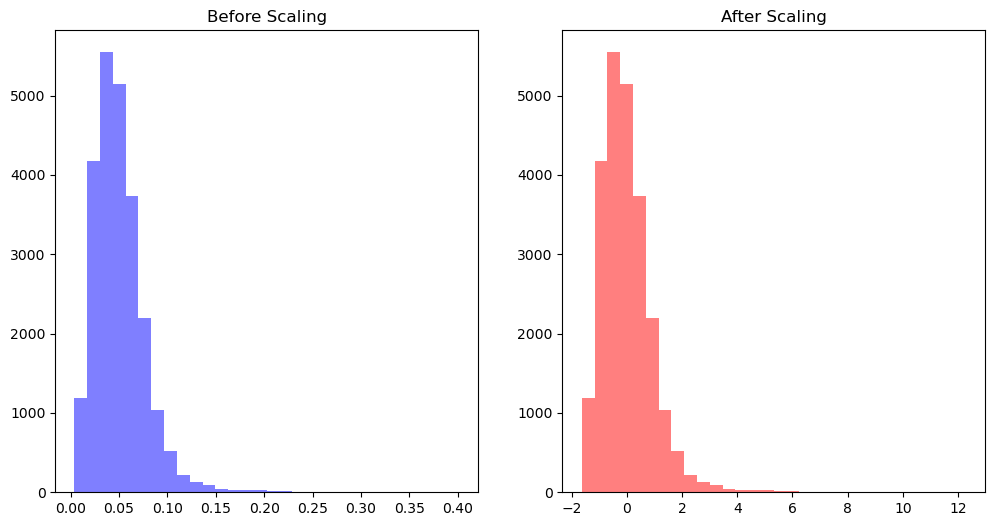

In [18]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

In [19]:
def filter_adjacency(edge_index, edge_attr, threshold):
    # Filter/select edges where the edge attributes are greater than the threshold in any of the five freq bands
    mask = (edge_attr > threshold).any(dim=1)
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

#### standard GCN

In [20]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_stand_GCN_best_model_logs\checkpoints\epoch=3385-train_loss=0.78-train_f1=0.72-val_loss=1.87-val_f1=0.34.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_stand_GCN_best_model_logs\
{'batch_size': 850, 'dropout': 0.19957362442904492, 'edge_threshold': 0.6870663022472054, 'learning_rate': 0.0061543071358829676, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-4.509507179260254, -2.97389554977417, -1.253..."
1,sub-87965301,4,2,"[-1.7900493144989014, -1.5398309230804443, -1...."
2,sub-87965301,4,1,"[-1.4388355016708374, -1.328490138053894, -2.1..."


In [21]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,1,1,4
1,sub-87967057,4,3,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,3,3,4


In [22]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.56      0.53         9
     HEALTHY       0.33      0.44      0.38         9
         MDD       0.43      0.33      0.38         9
         OCD       0.29      0.22      0.25         9
         SMC       0.56      0.56      0.56         9

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.42      0.42      0.42        45

f1_score: 0.4175647451963242

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.56      0.53         9
     HEALTHY       0.40      0.44      0.42         9
         MDD       0.20      0.11      0.14         9
         OCD       0.22      0.22      0.22         9
         SMC       0.36      0.44      0.40         9

    accuracy                           0.36        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

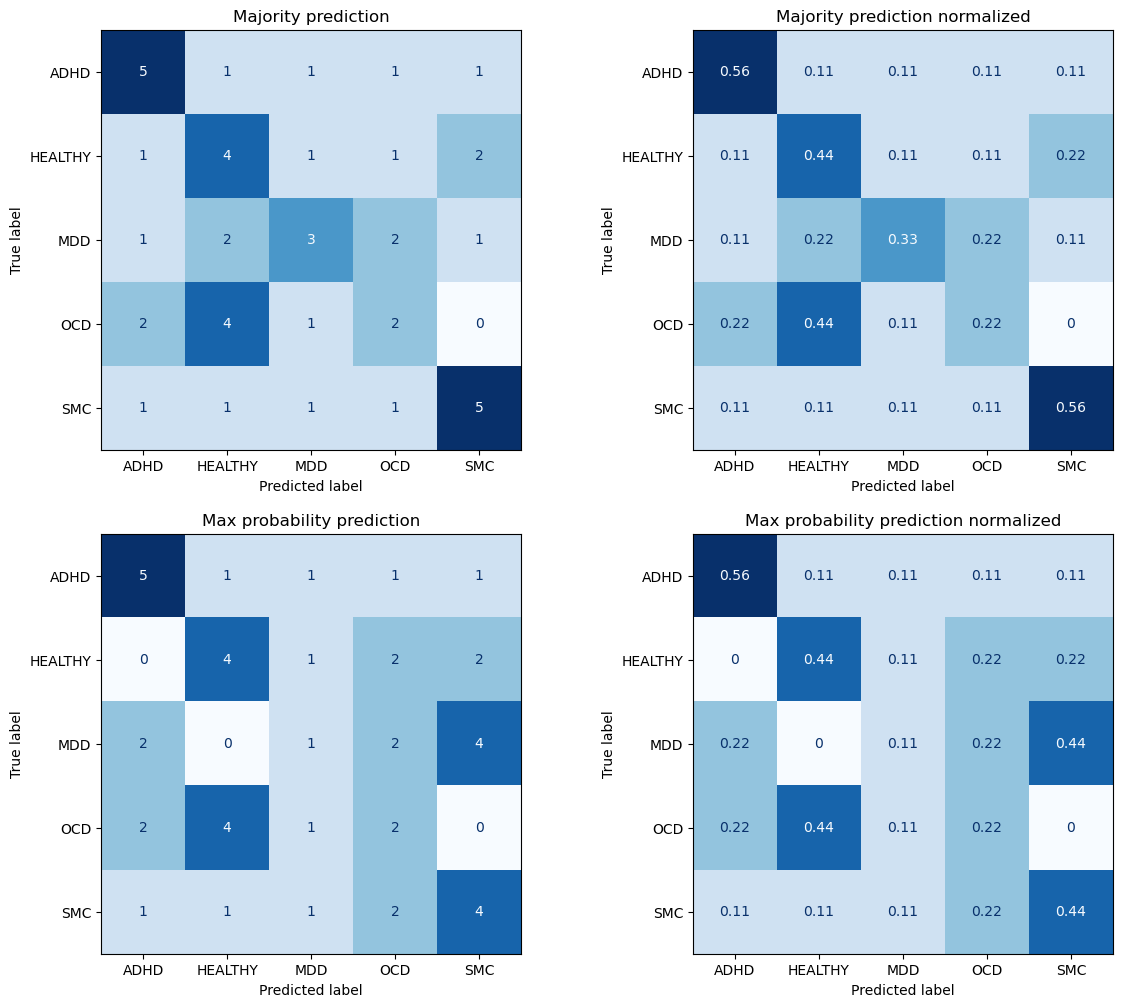

In [23]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [24]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_wo_edge_best_model_logs\checkpoints\epoch=352-train_loss=0.38-train_f1=0.89-val_loss=3.67-val_f1=0.35.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_wo_edge_best_model_logs\
{'batch_size': 510, 'dropout': 0.07556209443203989, 'edge_threshold': 0.8266629052093692, 'fc_layers': 5, 'learning_rate': 0.02669066643467487, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-8.740326881408691, -5.99491024017334, -4.673..."
1,sub-87965301,4,2,"[-3.9575154781341553, -4.279597282409668, -0.3..."
2,sub-87965301,4,0,"[-0.3536582589149475, -2.9699363708496094, -2...."


In [25]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,4,4
1,sub-87967057,1,1,4
2,sub-87967729,1,4,4
3,sub-87968045,4,4,4
4,sub-87968677,1,3,4


In [26]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.33      0.44      0.38         9
     HEALTHY       0.36      0.44      0.40         9
         MDD       0.33      0.33      0.33         9
         OCD       0.67      0.22      0.33         9
         SMC       0.30      0.33      0.32         9

    accuracy                           0.36        45
   macro avg       0.40      0.36      0.35        45
weighted avg       0.40      0.36      0.35        45

f1_score: 0.3526817042606516

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.40      0.44      0.42         9
     HEALTHY       0.44      0.44      0.44         9
         MDD       0.30      0.33      0.32         9
         OCD       0.50      0.22      0.31         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.40        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

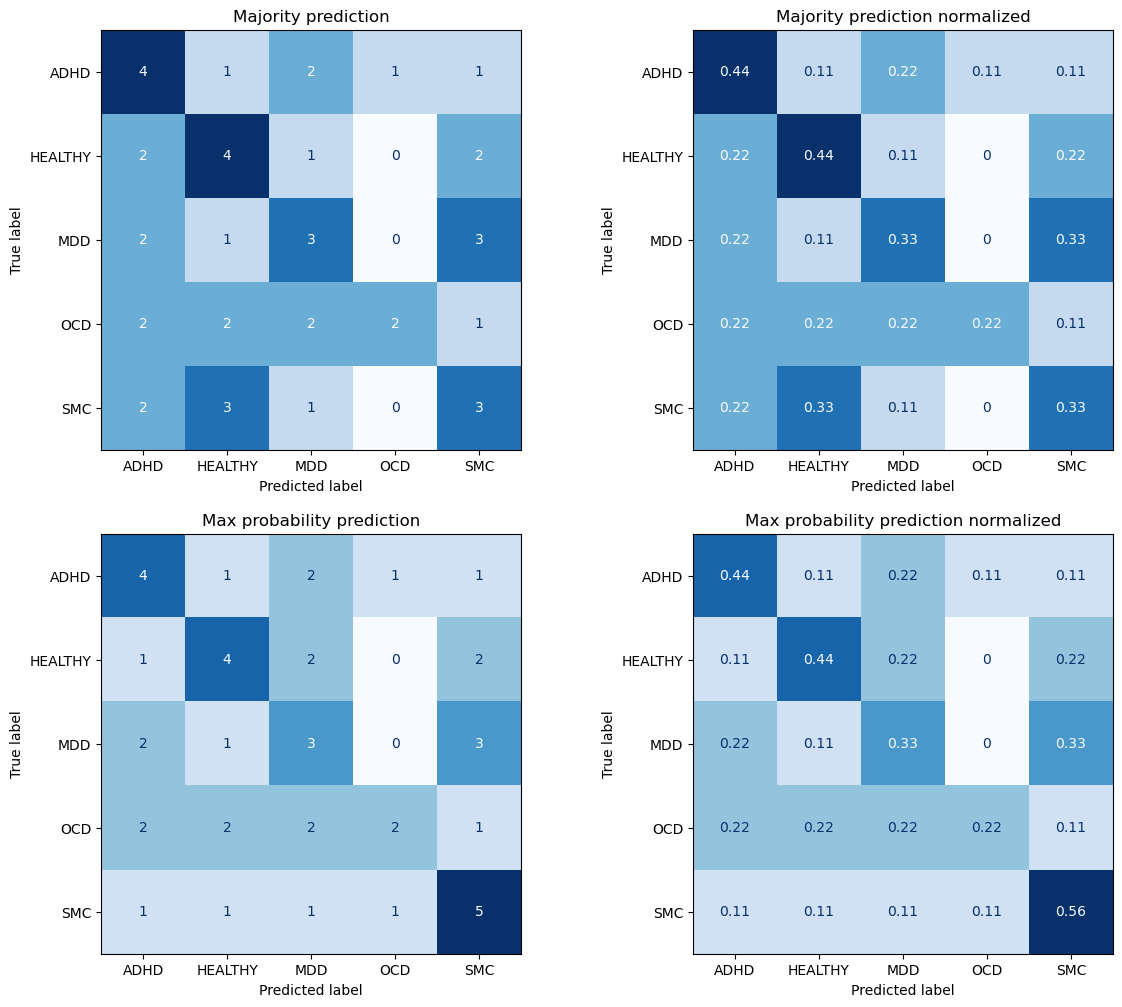

In [27]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [28]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_with_edge_best_model_logs\checkpoints\epoch=1087-train_loss=0.33-train_f1=0.92-val_loss=2.10-val_f1=0.32.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_with_edge_best_model_logs\
{'batch_size': 340, 'dropout': 0.118091618308195, 'fc_layers': 3, 'learning_rate': 0.0003330862976586279, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-3.4379446506500244, -2.719395637512207, -2.0..."
1,sub-87965301,4,3,"[-3.2587103843688965, -3.133702278137207, -2.2..."
2,sub-87965301,4,0,"[-0.7139869332313538, -1.6602106094360352, -1...."


In [29]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,1,1,4
1,sub-87967057,3,3,4
2,sub-87967729,1,1,4
3,sub-87968045,4,4,4
4,sub-87968677,3,3,4


In [30]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.45      0.56      0.50         9
     HEALTHY       0.36      0.56      0.43         9
         MDD       0.43      0.33      0.38         9
         OCD       0.29      0.22      0.25         9
         SMC       0.33      0.22      0.27         9

    accuracy                           0.38        45
   macro avg       0.37      0.38      0.37        45
weighted avg       0.37      0.38      0.37        45

f1_score: 0.36528985507246375

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.40      0.44      0.42         9
     HEALTHY       0.42      0.56      0.48         9
         MDD       0.57      0.44      0.50         9
         OCD       0.25      0.22      0.24         9
         SMC       0.38      0.33      0.35         9

    accuracy                           0.40        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

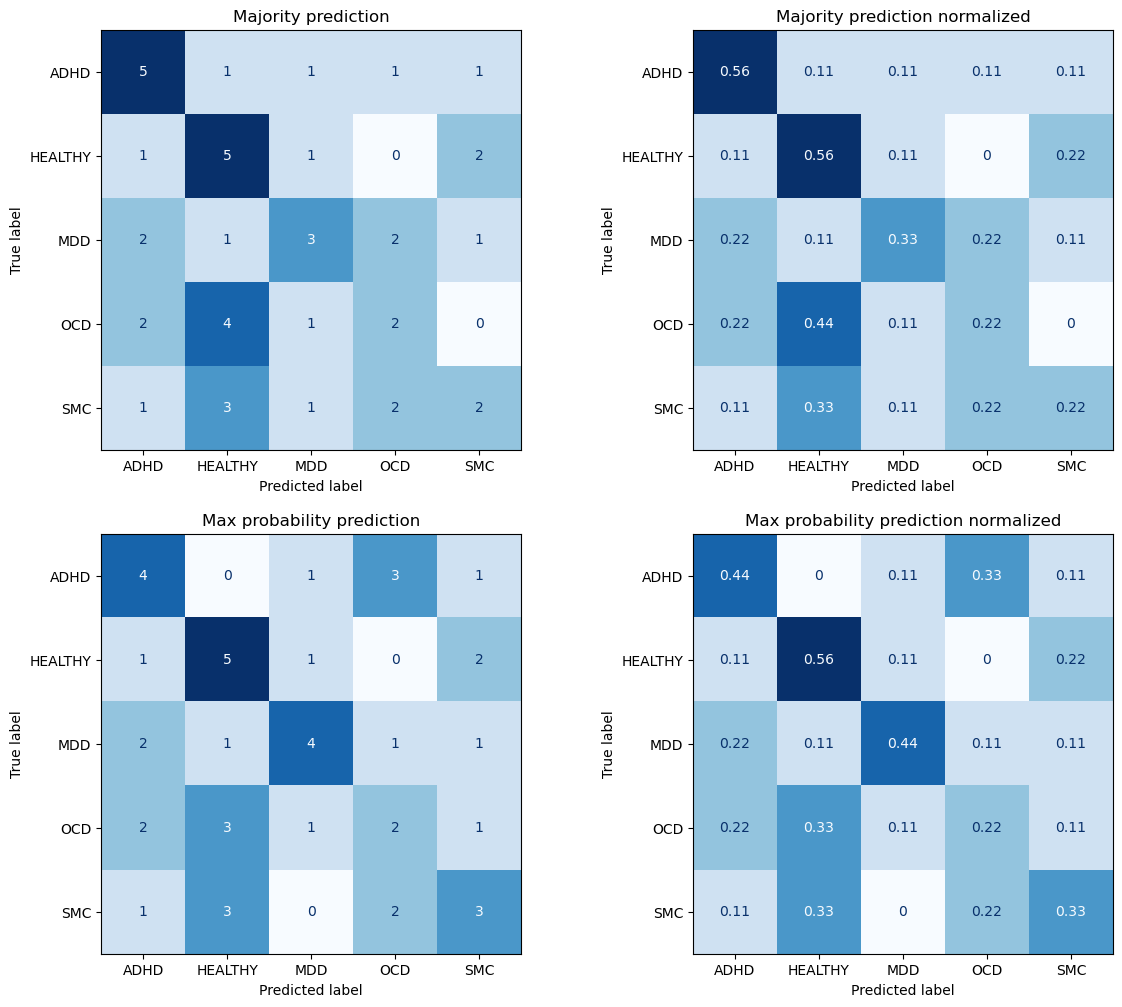

In [31]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

In [32]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['EO'][0]
baseline_val_ids = data_split_groups['EO'][1]
baseline_test_ids = data_split_groups['EO'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [eo_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
X_test = [eo_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[eo_y_list[i] for i in baseline_train_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
Y_test = [eo_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1440 720 540
len(eo_graph_dataset) = 2700
len(baseline_train_idxs) = 1440, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2700


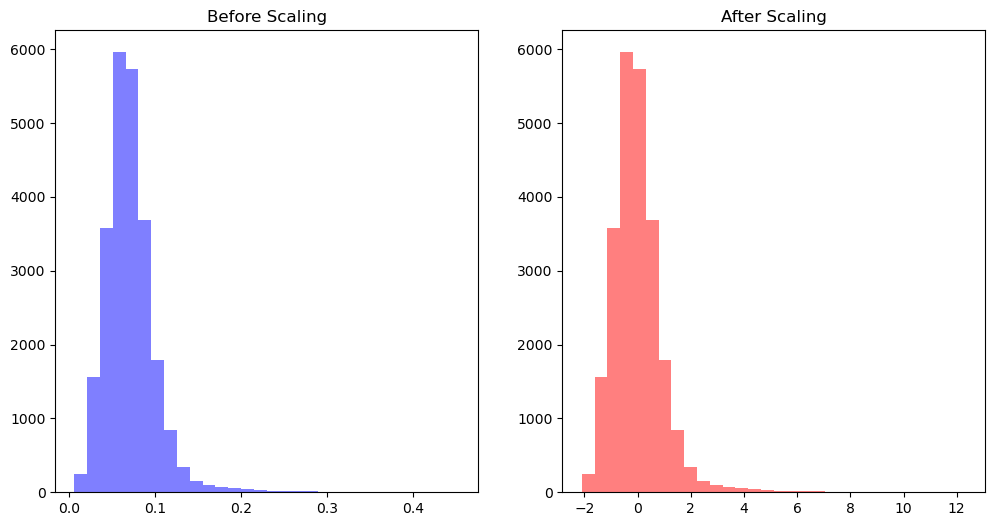

In [33]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

#### standard GCN

In [34]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_stand_GCN_best_model_logs\checkpoints\epoch=42-train_loss=1.45-train_f1=0.32-val_loss=1.55-val_f1=0.37.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_stand_GCN_best_model_logs\
{'batch_size': 170, 'dropout': 0.5117656632948554, 'edge_threshold': 0.8469389755689003, 'learning_rate': 0.05226985101691108, 'optimizer_name': 'Adam'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,4,"[-3.1189980506896973, -1.6198654174804688, -1...."
1,sub-87964717,4,4,"[-3.336059808731079, -1.9863624572753906, -1.7..."
2,sub-87964717,4,4,"[-3.9457125663757324, -1.3637590408325195, -2...."


In [35]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,4,4,4
1,sub-87966789,1,1,4
2,sub-87967509,3,2,4
3,sub-87967957,0,1,4
4,sub-87968541,2,2,4


In [36]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.31      0.44      0.36         9
     HEALTHY       0.33      0.33      0.33         9
         MDD       0.50      0.44      0.47         9
         OCD       0.38      0.33      0.35         9
         SMC       0.29      0.22      0.25         9

    accuracy                           0.36        45
   macro avg       0.36      0.36      0.35        45
weighted avg       0.36      0.36      0.35        45

f1_score: 0.35409982174688054

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.44      0.47         9
     HEALTHY       0.31      0.44      0.36         9
         MDD       0.40      0.44      0.42         9
         OCD       0.43      0.33      0.38         9
         SMC       0.29      0.22      0.25         9

    accuracy                           0.38        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

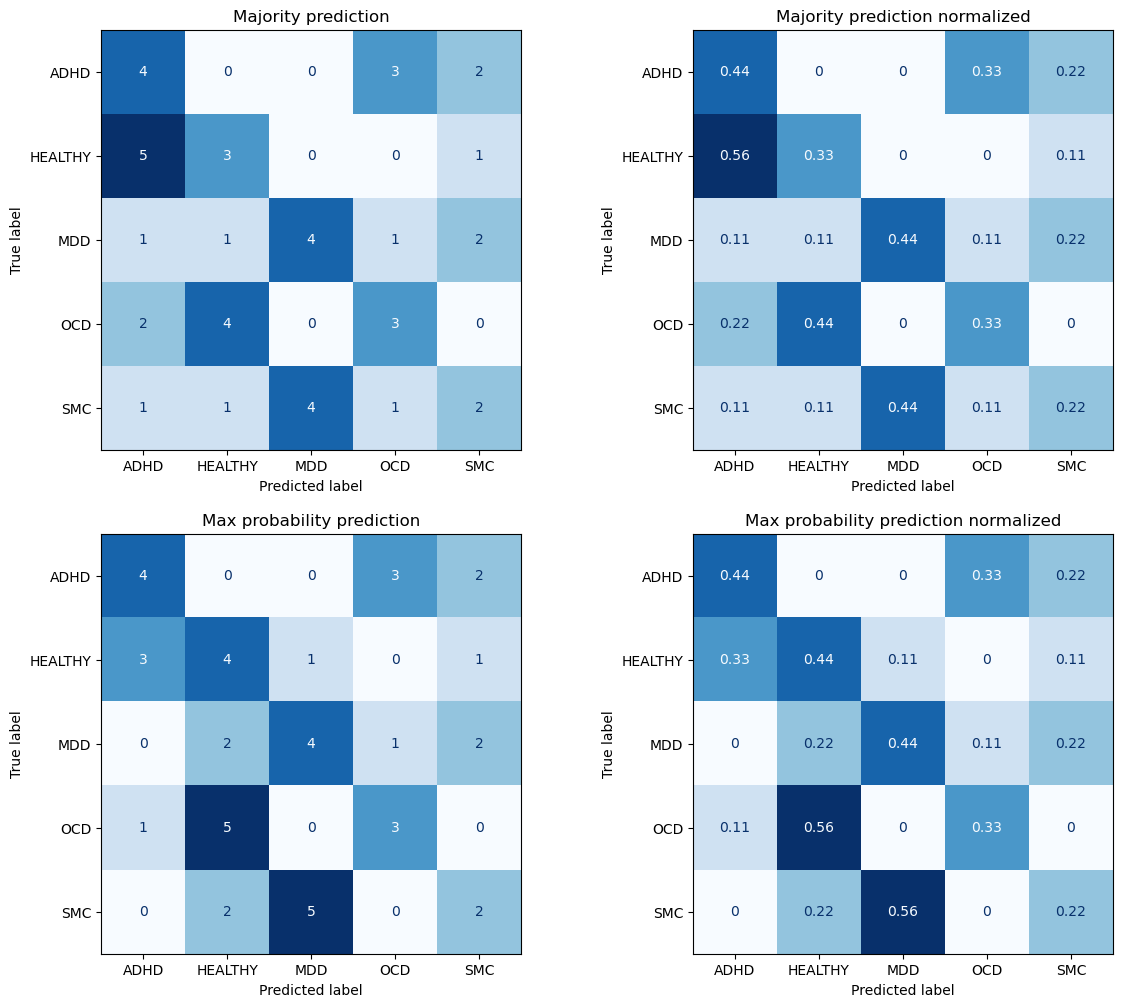

In [37]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [38]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_wo_edge_best_model_logs\checkpoints\epoch=332-train_loss=0.43-train_f1=0.84-val_loss=2.79-val_f1=0.35.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_wo_edge_best_model_logs\
{'batch_size': 170, 'dropout': 0.491883119465696, 'edge_threshold': 0.8646462022716686, 'fc_layers': 5, 'learning_rate': 0.005193133600048374, 'optimizer_name': 'SGD'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,4,"[-7.99851655960083, -7.99851655960083, -3.0647..."
1,sub-87964717,4,4,"[-14.130546569824219, -13.186034202575684, -9...."
2,sub-87964717,4,4,"[-7.559318542480469, -4.960681438446045, -6.36..."


In [39]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,4,4,4
1,sub-87966789,1,1,4
2,sub-87967509,3,3,4
3,sub-87967957,3,3,4
4,sub-87968541,4,4,4


In [40]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.62      0.56      0.59         9
     HEALTHY       0.45      0.56      0.50         9
         MDD       0.43      0.33      0.38         9
         OCD       0.57      0.44      0.50         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.49        45
   macro avg       0.50      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

f1_score: 0.4878851540616246

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.60      0.67      0.63         9
         MDD       0.33      0.33      0.33         9
         OCD       0.50      0.44      0.47         9
         SMC       0.46      0.67      0.55         9

    accuracy                           0.51        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

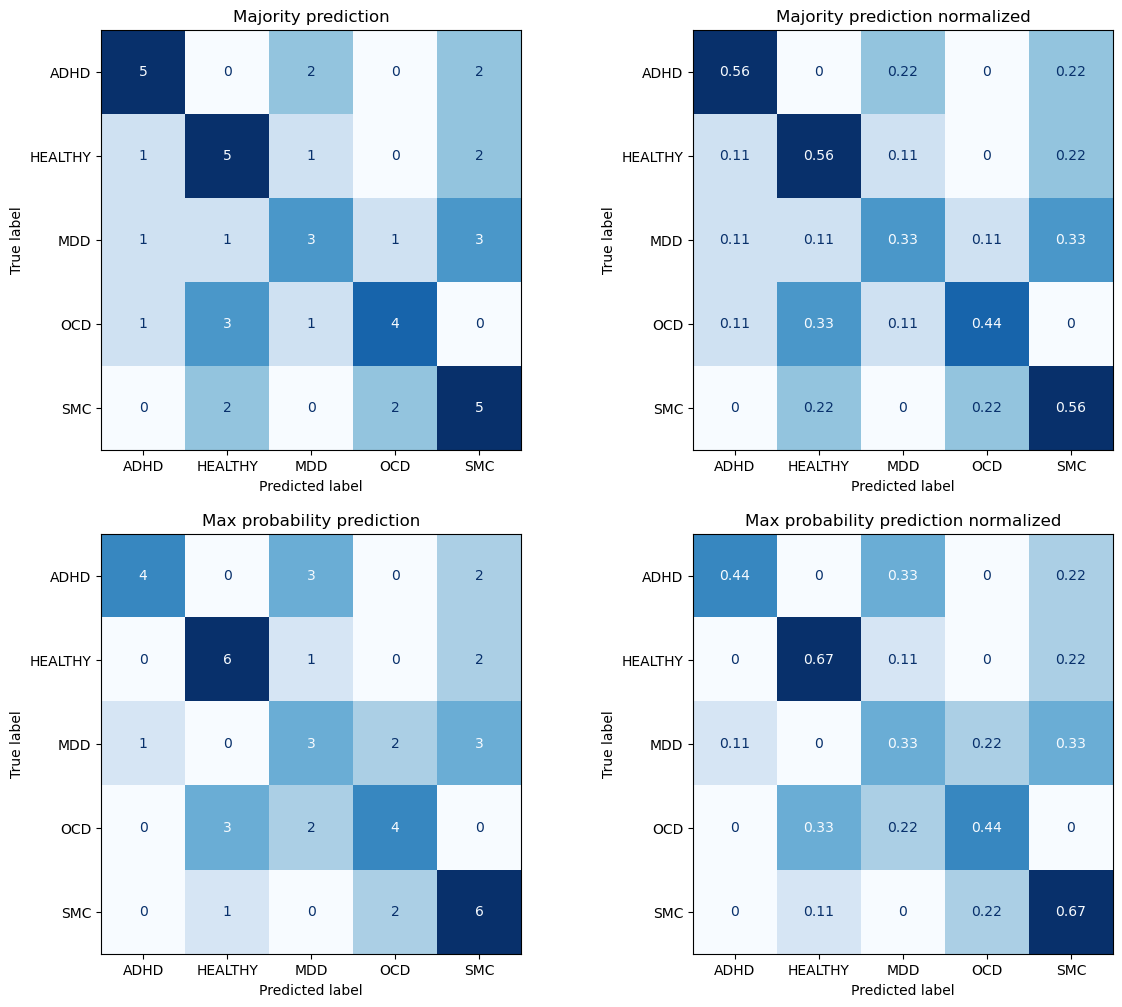

In [41]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [42]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_with_edge_best_model_logs\checkpoints\epoch=83-train_loss=0.04-train_f1=0.99-val_loss=6.89-val_f1=0.34.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_with_edge_best_model_logs\
{'batch_size': 510, 'dropout': 0.23748278915367405, 'fc_layers': 6, 'learning_rate': 0.00025437999522285833, 'optimizer_name': 'Adam'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,0,"[-0.0004646890447475016, -8.774155616760254, -..."
1,sub-87964717,4,4,"[-13.98231315612793, -13.98231315612793, -13.9..."
2,sub-87964717,4,1,"[-11.23279857635498, -0.055935703217983246, -1..."


In [43]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,2,2,4
1,sub-87966789,1,1,4
2,sub-87967509,2,2,4
3,sub-87967957,4,4,4
4,sub-87968541,2,2,4


In [44]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.60      0.67      0.63         9
         MDD       0.17      0.22      0.19         9
         OCD       0.20      0.22      0.21         9
         SMC       0.12      0.11      0.12         9

    accuracy                           0.33        45
   macro avg       0.38      0.33      0.34        45
weighted avg       0.38      0.33      0.34        45

f1_score: 0.34433141677723716

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.50      0.56      0.53         9
         MDD       0.18      0.22      0.20         9
         OCD       0.20      0.22      0.21         9
         SMC       0.11      0.11      0.11         9

    accuracy                           0.31        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

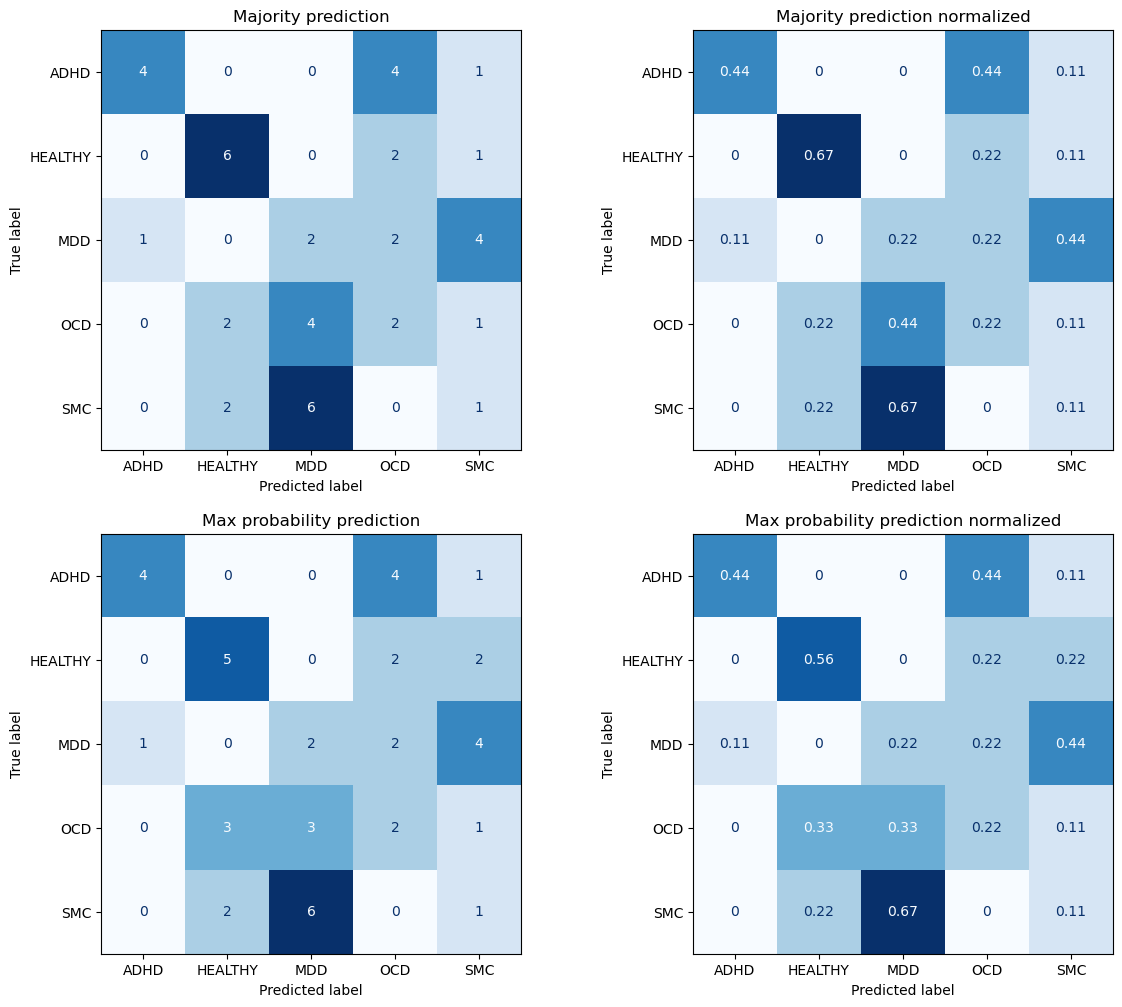

In [45]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

In [46]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['ratio'][0]
baseline_val_ids = data_split_groups['ratio'][1]
baseline_test_ids = data_split_groups['ratio'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [ratio_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
X_test = [ratio_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[ratio_y_list[i] for i in baseline_train_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
Y_test = [ratio_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1428 720 540
len(ratio_graph_dataset) = 2688
len(baseline_train_idxs) = 1428, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2688


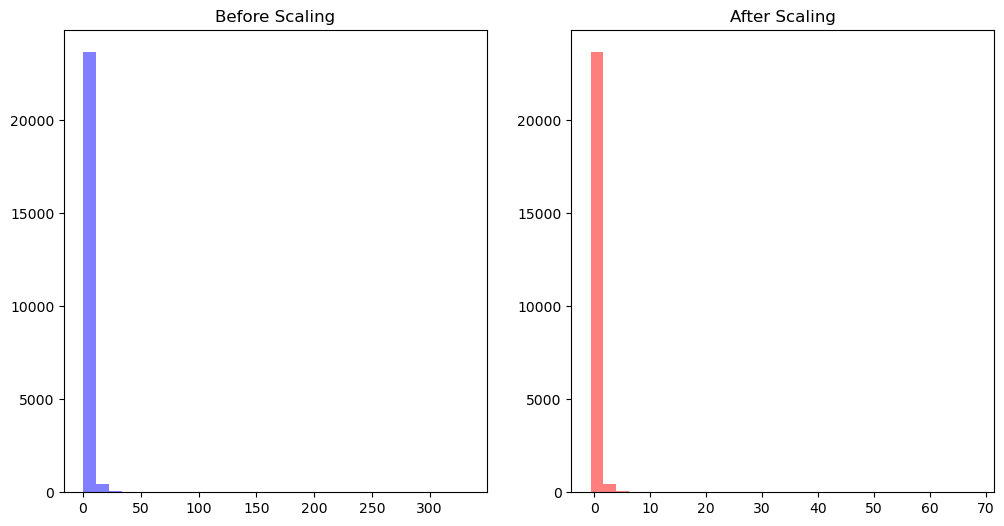

In [47]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

#### standard GCN

In [48]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_stand_GCN_best_model_logs\checkpoints\epoch=55-train_loss=1.02-train_f1=0.60-val_loss=1.98-val_f1=0.25.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_stand_GCN_best_model_logs\
{'batch_size': 510, 'dropout': 0.12245267416796006, 'edge_threshold': 0.7575571400876487, 'learning_rate': 0.0006242859250070882, 'optimizer_name': 'RMSprop'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,1,"[-2.3770508766174316, -1.196850061416626, -1.3..."
1,sub-87965301,4,3,"[-3.103524684906006, -1.0806896686553955, -2.9..."
2,sub-87965301,4,0,"[-1.1346337795257568, -2.495098352432251, -1.5..."


In [49]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,0,4
1,sub-87967057,4,4,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [50]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.46      0.67      0.55         9
     HEALTHY       0.43      0.33      0.38         9
         MDD       0.00      0.00      0.00         9
         OCD       0.42      0.56      0.48         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.42        45
   macro avg       0.34      0.42      0.37        45
weighted avg       0.34      0.42      0.37        45

f1_score: 0.37456709956709955

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.33      0.40         9
     HEALTHY       0.50      0.44      0.47         9
         MDD       0.00      0.00      0.00         9
         OCD       0.40      0.67      0.50         9
         SMC       0.25      0.33      0.29         9

    accuracy                           0.36        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

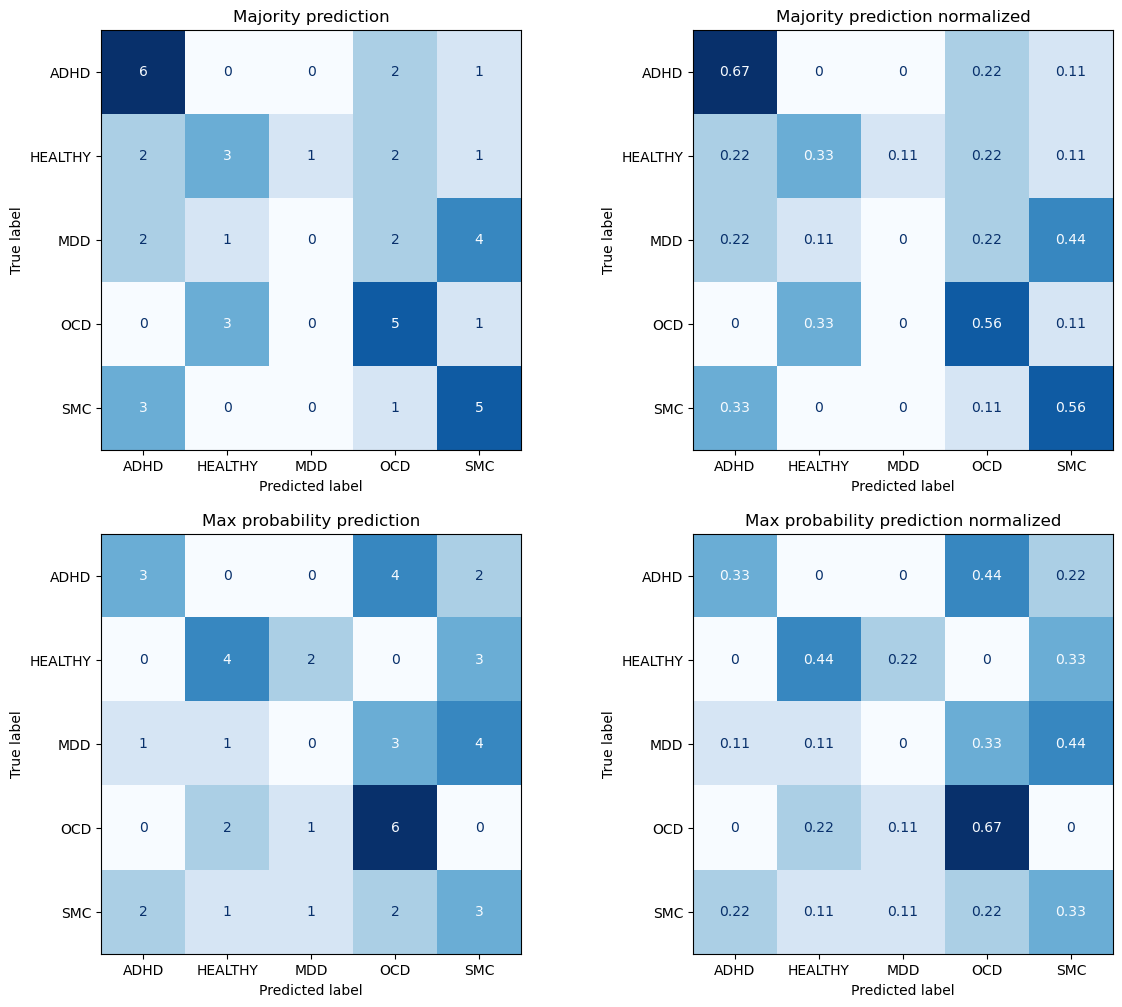

In [51]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [52]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_wo_edge_best_model_logs\checkpoints\epoch=2503-train_loss=0.00-train_f1=1.00-val_loss=5.14-val_f1=0.22.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_wo_edge_best_model_logs\
{'batch_size': 850, 'dropout': 0.05066888473079148, 'edge_threshold': 0.6798223930859607, 'fc_layers': 3, 'learning_rate': 0.010054058167807403, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,3,"[-4.330561637878418, -0.8072435259819031, -3.5..."
1,sub-87965301,4,1,"[-1.8111358880996704, -0.2457342892885208, -8...."
2,sub-87965301,4,0,"[-0.0001494772732257843, -12.75162410736084, -..."


In [53]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,3,3,4
1,sub-87967057,4,4,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [54]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.44      0.89      0.59         9
     HEALTHY       0.50      0.22      0.31         9
         MDD       0.17      0.11      0.13         9
         OCD       0.50      0.22      0.31         9
         SMC       0.31      0.44      0.36         9

    accuracy                           0.38        45
   macro avg       0.38      0.38      0.34        45
weighted avg       0.38      0.38      0.34        45

f1_score: 0.340989380989381

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.78      0.61         9
     HEALTHY       0.67      0.44      0.53         9
         MDD       0.00      0.00      0.00         9
         OCD       0.43      0.33      0.38         9
         SMC       0.21      0.33      0.26         9

    accuracy                           0.38        45
   macro avg       

Text(0.5, 1.0, 'Max probability prediction normalized')

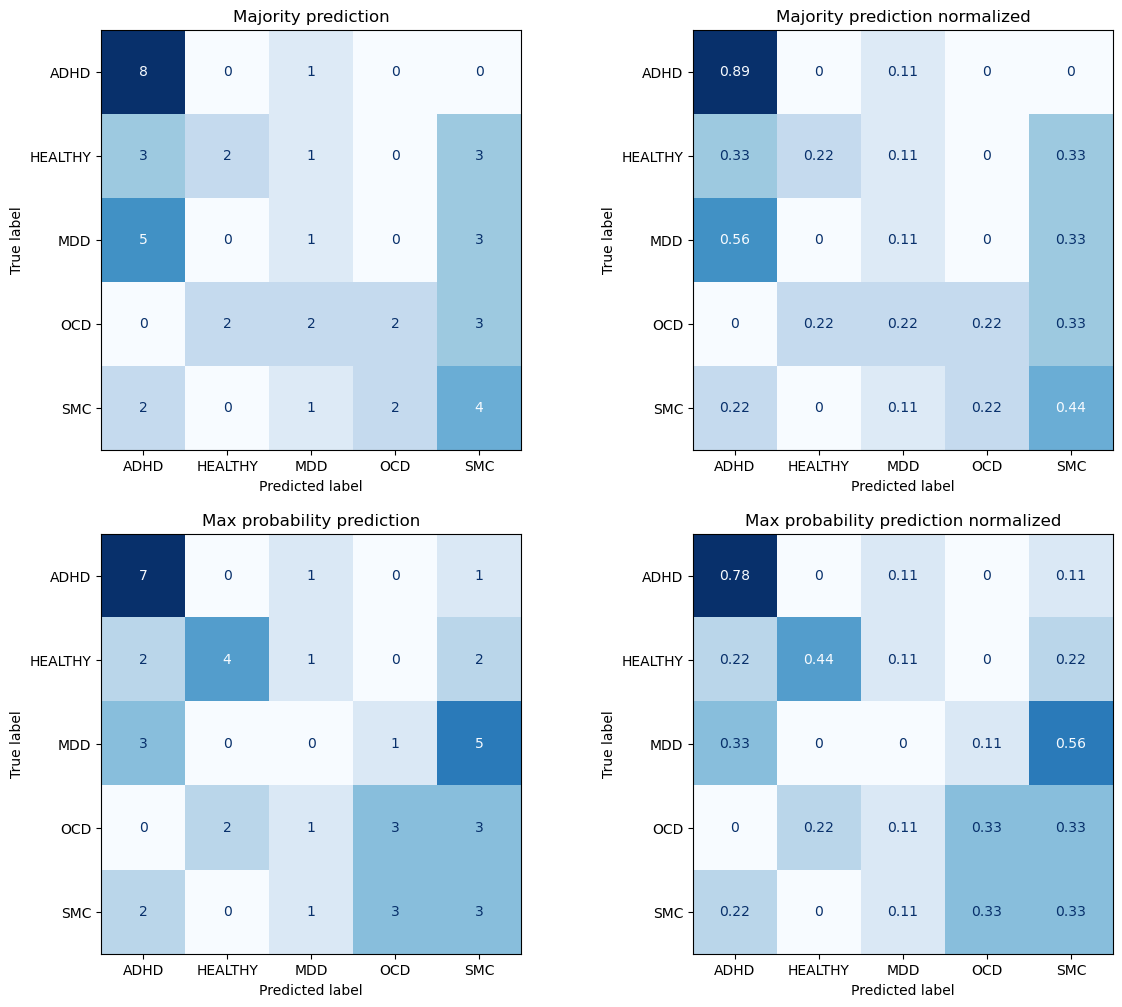

In [55]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [56]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_with_edge_best_model_logs\checkpoints\epoch=423-train_loss=0.05-train_f1=0.99-val_loss=8.08-val_f1=0.23.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)
trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_with_edge_best_model_logs\
{'batch_size': 850, 'dropout': 0.2532377504886759, 'fc_layers': 7, 'learning_rate': 2.8351247448816293e-05, 'optimizer_name': 'RMSprop'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,1,"[-7.871859073638916, -0.12356747686862946, -2...."
1,sub-87965301,4,1,"[-15.418563842773438, -4.029192859889008e-05, ..."
2,sub-87965301,4,0,"[-6.12716976320371e-05, -17.504812240600586, -..."


In [57]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,3,4
1,sub-87967057,4,4,4
2,sub-87967729,4,2,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [58]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.58      0.78      0.67         9
     HEALTHY       0.40      0.22      0.29         9
         MDD       0.19      0.33      0.24         9
         OCD       0.33      0.22      0.27         9
         SMC       0.50      0.33      0.40         9

    accuracy                           0.38        45
   macro avg       0.40      0.38      0.37        45
weighted avg       0.40      0.38      0.37        45

f1_score: 0.37180952380952387

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.54      0.78      0.64         9
     HEALTHY       0.50      0.22      0.31         9
         MDD       0.20      0.44      0.28         9
         OCD       0.40      0.22      0.29         9
         SMC       0.67      0.22      0.33         9

    accuracy                           0.38        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

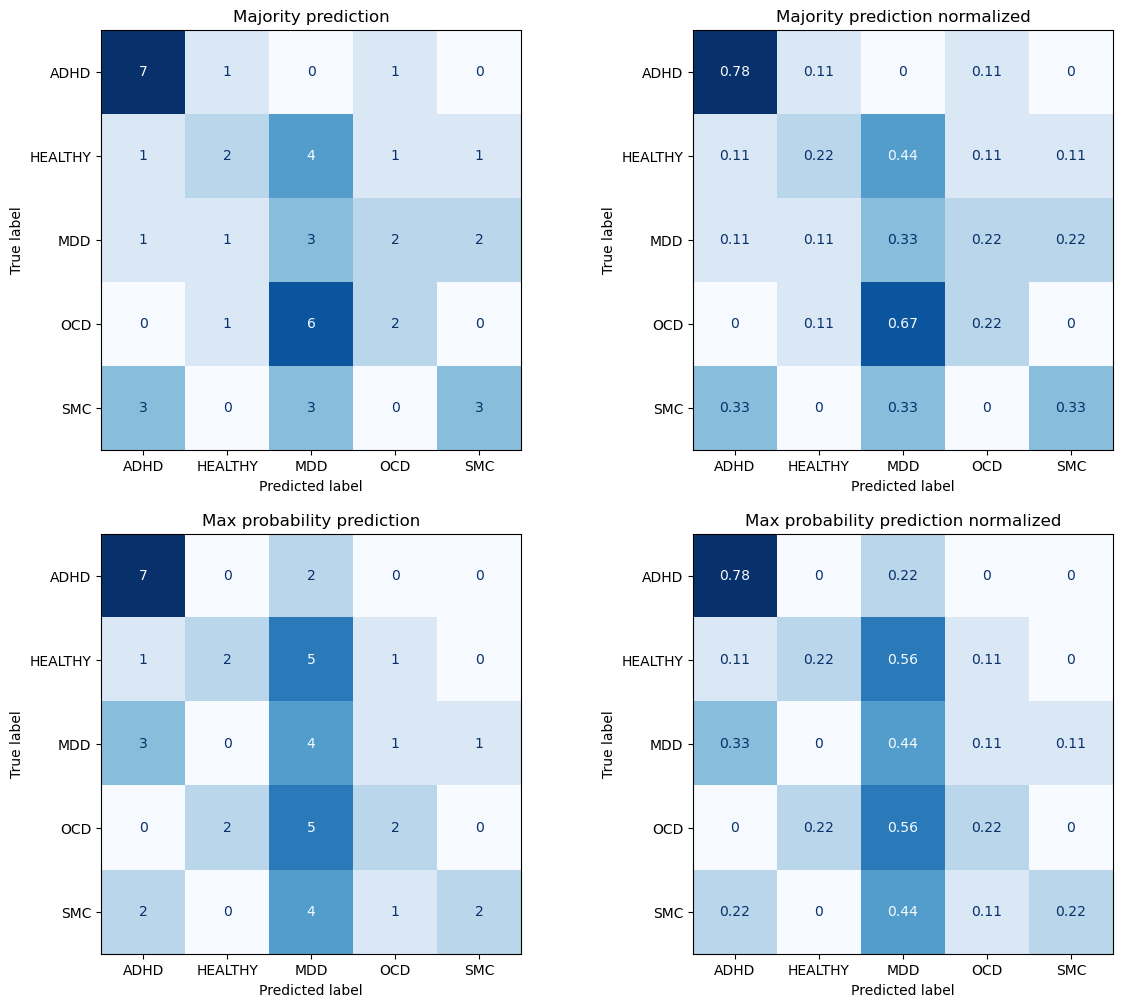

In [59]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')